### 패스트 캠퍼스 샘플

> 데이터 전처리
    > state == "COMPLETED"
    > format == "
    > type == "PAYMENT"
    > 맥북 제공 프로모션 체크

- 매출 수 : df['type'] == 'PAYMENT'  -   df['type'] == 'REFUND'
- 쿠폰사용 수 : df['type'] == 'PAYMENT'  - df['type'] == 'REFUND'

- 쿠폰사용 액 : df['type'] == 'PAYMENT'  - df['type'] == 'REFUND'

- 매출액 기준 : df['transaction_amount'] 관계없이 다 더함



### import

In [7]:
import numpy as np
import pandas as pd
from fbprophet import Prophet # version 0.6

import seaborn as sns
# import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import LinearRegression

import urllib.request
import datetime
import json
import glob
import sys
import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
# 그래프 해상도 설정
%config InlineBackend.figure_formats = {'png', 'retina'}


# matplotlib 한글 폰트 출력코드
# 출처 : 데이터공방( https://kiddwannabe.blog.me)

import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False   

In [3]:
# 모든 컬럼 보기
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

### 0. 데이터 전처리

#### 0.1 불러오기

In [3]:
# read
df = pd.read_excel("data/final.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105412 entries, 0 to 105411
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      105412 non-null  int64         
 1   customer_id             105409 non-null  float64       
 2   course_id               100209 non-null  float64       
 3   type                    105412 non-null  object        
 4   state                   105412 non-null  object        
 5   course_title            105397 non-null  object        
 6   category_title          105394 non-null  object        
 7   format                  105397 non-null  object        
 8   completed_at            105412 non-null  datetime64[ns]
 9   transaction_amount      105412 non-null  int64         
 10  coupon_title            31817 non-null   object        
 11  coupon_discount_amount  31817 non-null   float64       
 12  sale_price              104285

In [6]:
# 데이터 내용 확인
df.head(2)

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at
0,970634,504760.0,201435.0,ORDER,CANCELLED,올인원 패키지 : 알고리즘 기술면접 완전 정복,프로그래밍,올인원,2021-03-28 15:00:11,90500,NaN,NaN,110500.0,110500.0,NaN,VBANK,개발자 커리어,NaT
1,970650,432862.0,203178.0,ORDER,CANCELLED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:16:53,96000,NaN,NaN,116000.0,116000.0,NaN,CARD,영상 편집,2020-12-02


#### 0.2 state type format 필요한 요소 정리

type

>'PAYMENT' - 주문  
>'REFUND'- 환불

-----삭제-------
>'ORDER'  
>'TRANSACTION'

state

> 'COMPLETED' 정상 결제  

----- 삭제 -----
>'CANCELLED'  
>'PENDING'  
>'DELETED'  
>'REQUESTED'

format : 수업 판매 종류


#### B2C
- '올인원' : 주 판매 강의, 여러 강의 묶음 판매 / '프로모션 :', '[한정판매]'포함 제품 분리 분석 필요
- 'RED' : 프리미엄 상품, 유명인, 전문가 초빙하여 높은 금액 판매
- '이벤트' : 120일 수강 올인원 패키지  

#### B2B, B2G
- 'B2B 온라인'
- 'B2B'
- 'B2G'
  
#### 제로베이스 판매중
- '온라인 완주반': 온라인 강의 후 환급 시리즈
- '하루10분컷' : 10분 독서 강의
- '캠프' : 완주반 시리즈 중 일부 / 

#### Coloso 판매중
- '콜로소' : 시각화 특화 강의
  
#### 판매 중단
- 'MBA' : 경영의 신: core MBA / 현재 판매중단 - 전화확인
- '스쿨 온라인' : 스프링 아카데미아 강의 시리즈/ 세미나형 강의/현재 판매중단 /https://fastcampus.co.kr/spring_academia_list
- '아카이브' : Archive-Octane Render BASIC / 현재 판매중단
- '관리' : test용
  
#### 오프라인
- '스쿨' : 오프라인 취업 완성 시리즈 /https://fastcampus.co.kr/data_school_lv1/ 



- nan : df["type"] == "TRANSACTION"	or  df["state"] == "DELETED" / 무시

현재 판매 중인 온라인 데이터만 분석
B2C와 B2B&B2G 분리 분석

#### 0.3 사용할 데이터 프레임 정의 [df_condition_B2C, df_condition_B2BG]

In [5]:
# format, type, state 필요한 행만 불러오기
df_condition_format_B2C =  ['올인원','RED', '이벤트']
df_condition_format_B2B =  ['B2B 온라인','B2B', 'B2G']
df_condition_type =  ['ORDER','TRANSACTION']
df_condition_state = ['COMPLETED']

# B2C 데이터 프레임
df_condition_B2C = df[(~(df.type.isin(df_condition_type)) 
                   & (df.state.isin(df_condition_state))) 
                  & (df.format.isin(df_condition_format_B2C))]
# B2B & B2G 데이터 프레임
df_condition_B2BG = df[(~(df.type.isin(df_condition_type)) 
                   & (df.state.isin(df_condition_state))) 
                  & (df.format.isin(df_condition_format_B2B))]

### 0.4 업계 트렌트 분석- 네이버 검색API

In [4]:
class NaverDataLabOpenAPI():
    """
    네이버 데이터랩 오픈 API 컨트롤러 클래스
    """

    def __init__(self, client_id, client_secret):
        """
        인증키 설정 및 검색어 그룹 초기화
        """
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"

    def add_keyword_groups(self, group_dict):
        """
        검색어 그룹 추가
        """

        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }

        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")

    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        """
        요청 결과 반환
        timeUnit - 'date', 'week', 'month'
        device - None, 'pc', 'mo'
        ages = [], ['1' ~ '11']
        gender = None, 'm', 'f'
        """

        # Request body
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)

        # Results
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id", self.client_id)
        request.add_header("X-Naver-Client-Secret", self.client_secret)
        request.add_header("Content-Type", "application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode == 200):
            # Json Result
            result = json.loads(response.read())

            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(
                    columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])

        else:
            print("Error Code:" + rescode)

        return self.df

    def plot_daily_trend(self):
        """
        일 별 검색어 트렌드 그래프 출력
        """
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig = plt.figure(figsize=(12, 6))
        plt.title('일 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'],
                         y=self.df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')

        return fig

    def plot_monthly_trend(self):
        """
        월 별 검색어 트렌드 그래프 출력
        """
        df = self.df.copy()
        df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean(
        ).droplevel(0).reset_index().rename(columns={'날짜': '월'})
        df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean(
        ).droplevel(1).reset_index().rename(columns={'날짜': '년도'})

        df = pd.merge(df_1[['년도']], df_0, how='left',
                      left_index=True, right_index=True)
        df['날짜'] = pd.to_datetime(df[['년도', '월']].assign(일=1).rename(
            columns={"년도": "year", "월": 'month', '일': 'day'}))

        colList = df.columns.drop(['날짜', '년도', '월'])
        n_col = len(colList)

        fig = plt.figure(figsize=(12, 6))
        plt.title('월 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')

        return fig

In [14]:
keyword_group_set = {
    'keyword_group_1': {'groupName': "클래스101", 'keywords': ["클래스 101", "클원", "클래스원오원"]},
    'keyword_group_2': {'groupName': "패스트캠퍼스", 'keywords': ["패스트 캠퍼스", "패캠"]},
    'keyword_group_3': {'groupName': "인프런", 'keywords': ["인프런"]},
}

In [30]:
# API 인증 정보 설정
client_id = "Q0uBPnHdOQCjFnWCx__G"
client_secret = "q58k8s2w6l"

# 요청 파라미터 설정
startDate = "2017-01-01"
endDate = "2021-09-30"
timeUnit = 'date'
device = ''
ages = []
gender = ''

# 데이터 프레임 정의
naver = NaverDataLabOpenAPI(client_id=client_id, client_secret=client_secret)

naver.add_keyword_groups(keyword_group_set['keyword_group_1'])
naver.add_keyword_groups(keyword_group_set['keyword_group_2'])
naver.add_keyword_groups(keyword_group_set['keyword_group_3'])


shearch = naver.get_data(startDate, endDate, timeUnit, device, ages, gender)

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2
>>> Num of keywordGroups: 3


(0.0, 15.0)

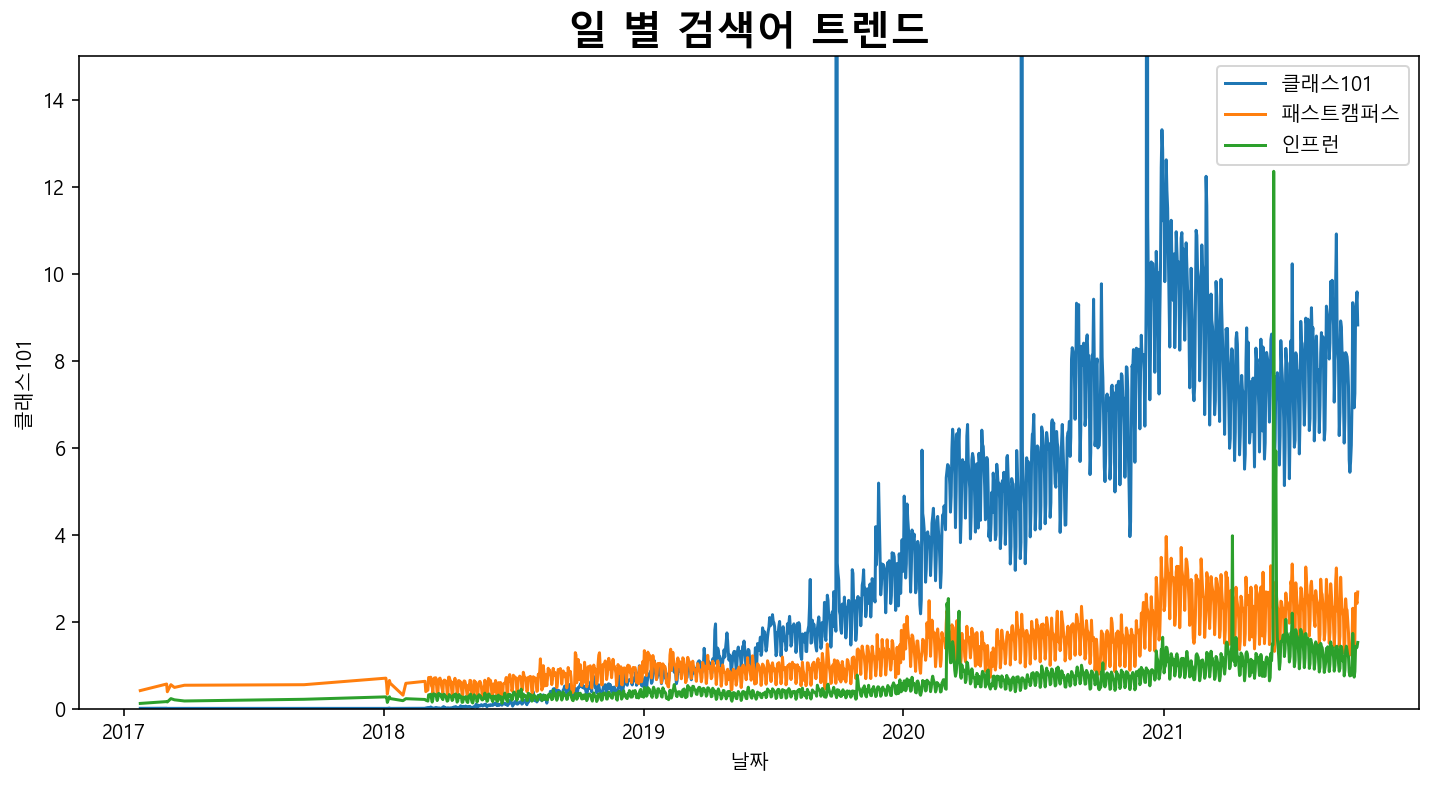

In [22]:
# 일별 검색어 트렌드
fig_1 = naver.plot_daily_trend()
plt.ylim(0,15)

# 사용 # 월별 검색어 트렌드


(0.0, 12.0)

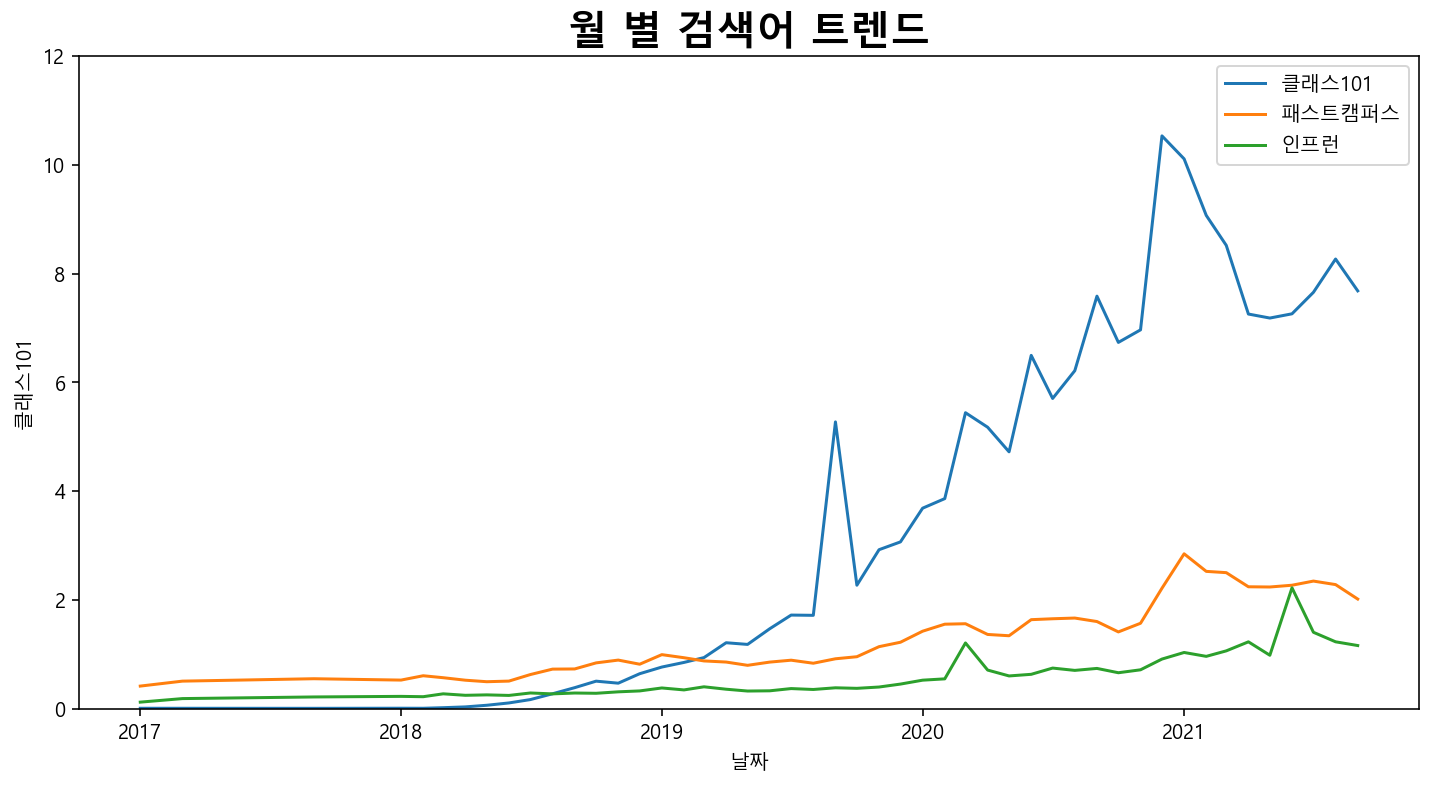

In [31]:
# 월별 검색어 트렌드
fig_2 = naver.plot_monthly_trend()
plt.ylim(0,12)

### 1.0 df_condition_B2C 전처리

In [8]:
df_condition_B2C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50009 entries, 4 to 105411
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      50009 non-null  int64         
 1   customer_id             50009 non-null  float64       
 2   course_id               47858 non-null  float64       
 3   type                    50009 non-null  object        
 4   state                   50009 non-null  object        
 5   course_title            50009 non-null  object        
 6   category_title          50009 non-null  object        
 7   format                  50009 non-null  object        
 8   completed_at            50009 non-null  datetime64[ns]
 9   transaction_amount      50009 non-null  int64         
 10  coupon_title            22624 non-null  object        
 11  coupon_discount_amount  22624 non-null  float64       
 12  sale_price              49981 non-null  float

#### 1.0.1 sale_price 결측치 제거

In [6]:
# sale_price 결측치 확인
df_condition_B2C[df_condition_B2C['sale_price'].isnull()]

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at
2335,977020,472951.0,202555.0,PAYMENT,COMPLETED,올인원 패키지 : 리눅스 실전 정복,프로그래밍,올인원,2021-03-30 13:42:51,101000,NaN,NaN,NaN,NaN,NaN,TRANSFER,DevOps,2020-03-23 00:00:00
2342,977019,461557.0,203015.0,PAYMENT,COMPLETED,올인원 패키지 : SNS 콘텐츠 기획/제작 MAX 2020,마케팅,올인원,2021-03-30 13:42:51,88000,NaN,NaN,NaN,NaN,NaN,TRANSFER,SNS마케팅,2020-07-09 00:00:00
3806,981836,472165.0,201133.0,PAYMENT,COMPLETED,"올인원 패키지 : HTML/CSS, JavaScript",프로그래밍,올인원,2021-03-31 15:35:57,85000,NaN,NaN,NaN,NaN,NaN,TRANSFER,개발자 커리어,2019-07-11 00:00:00
12669,1008518,495392.0,202545.0,PAYMENT,COMPLETED,올인원 패키지 : 부동산 디벨로퍼,부동산/금융,올인원,2021-04-13 13:29:31,500,NaN,NaN,NaN,NaN,NaN,TRANSFER,부동산 개발,2020-03-31 00:00:00
18558,1030483,508573.0,204159.0,PAYMENT,COMPLETED,부동산 디벨로퍼 아카데미 : 인허가,부동산/금융,올인원,2021-04-25 20:29:57,168100,NaN,NaN,NaN,NaN,NaN,TRANSFER,부동산 개발,2021-02-10 00:00:00
19810,1032240,502988.0,202712.0,PAYMENT,COMPLETED,올인원 패키지 : 통계와 엑셀을 활용한 데이터 분석,업무 생산성,올인원,2021-04-26 18:18:05,120500,NaN,NaN,NaN,NaN,NaN,TRANSFER,엑셀/VBA,2020-06-17 00:00:00
21725,1036918,510396.0,204159.0,PAYMENT,COMPLETED,부동산 디벨로퍼 아카데미 : 인허가,부동산/금융,올인원,2021-04-28 16:40:35,138000,NaN,NaN,NaN,NaN,NaN,TRANSFER,부동산 개발,2021-02-10 00:00:00
21726,1036919,510396.0,202545.0,PAYMENT,COMPLETED,올인원 패키지 : 부동산 디벨로퍼,부동산/금융,올인원,2021-04-28 16:40:35,125500,NaN,NaN,NaN,NaN,NaN,TRANSFER,부동산 개발,2020-03-31 00:00:00
44659,1110082,543961.0,203178.0,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-05-31 10:30:00,100000,NaN,NaN,NaN,NaN,NaN,TRANSFER,영상 편집,2020-12-02 00:00:00
44801,1110084,544215.0,202612.0,PAYMENT,COMPLETED,올인원 패키지 : 김기현의 딥러닝을 활용한 자연어처리 입문,데이터사이언스,올인원,2021-05-31 12:27:37,142500,NaN,NaN,NaN,NaN,NaN,TRANSFER,딥러닝/인공지능,2020-04-27 00:00:00


In [7]:
# sale_price 결측치 제거
df_condition_B2C = df_condition_B2C.dropna(subset = ['sale_price'])

In [ ]:
# 확인
df_condition_B2C[df_condition_B2C['sale_price'].isnull()]

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at


In [16]:
# csv로 저장
df_condition_B2C.to_csv('Final_CONDITION_B2C.csv')

In [ ]:
df_condition_B2C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49981 entries, 4 to 105411
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      49981 non-null  int64         
 1   customer_id             49981 non-null  float64       
 2   course_id               47830 non-null  float64       
 3   type                    49981 non-null  object        
 4   state                   49981 non-null  object        
 5   course_title            49981 non-null  object        
 6   category_title          49981 non-null  object        
 7   format                  49981 non-null  object        
 8   completed_at            49981 non-null  datetime64[ns]
 9   transaction_amount      49981 non-null  int64         
 10  coupon_title            22624 non-null  object        
 11  coupon_discount_amount  22624 non-null  float64       
 12  sale_price              49981 non-null  float

#### 1.0.2 데이터 형식 변경 : customer_id, 	course_id	실수 => 문자열

course_id결측치 내용 입력 : df_condition_B2C["course_id"] == '0'

In [8]:
# course_id 결측치 0으로 채운다
df_condition_B2C["course_id"].fillna(0, inplace =True)

In [9]:
# 실수 => 정수 => 문자열
df_condition_B2C["customer_id"] = df_condition_B2C["customer_id"].astype(int)
df_condition_B2C["customer_id"] = df_condition_B2C["customer_id"].astype(str)

df_condition_B2C["course_id"] = df_condition_B2C["course_id"].astype(int)
df_condition_B2C["course_id"] = df_condition_B2C["course_id"].astype(str)

In [8]:
#변환 확인
df_condition_B2C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49981 entries, 4 to 105411
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      49981 non-null  int64         
 1   customer_id             49981 non-null  object        
 2   course_id               49981 non-null  object        
 3   type                    49981 non-null  object        
 4   state                   49981 non-null  object        
 5   course_title            49981 non-null  object        
 6   category_title          49981 non-null  object        
 7   format                  49981 non-null  object        
 8   completed_at            49981 non-null  datetime64[ns]
 9   transaction_amount      49981 non-null  int64         
 10  coupon_title            22624 non-null  object        
 11  coupon_discount_amount  22624 non-null  float64       
 12  sale_price              49981 non-null  float

#### 1.0.3 테스트용 쿠폰 사용 데이터 제거 

제거할 쿠폰 리스트 추출 - 태블로로 추출
1. 할인율 90% 이상인 쿠폰 title 확인
2.  title 목록 csv저장 
3. 테스트용, 검수용, 내부 이용자용, 보상용 제외, 이지웰, 이제너두 등 고객사 지급 쿠폰 제외
4. 이벤트 쿠폰(1+1)등은 (실제 이용자로 인식) / 구매 이용객 많은 것 우선 확인

=> 이상 데이터 총 데이터의 2% 정도, 검출되지 않은 것은 무시

In [10]:
coupon_drop_list = pd.read_csv("coupon_drop.csv")

In [11]:
coupon_drop_list["Coupon Title"]

0                                호준 테스트
1        프로젝트로 배우는 부동산 PF 17기_REC.ON:VC
2                    패캐머_온라인 쿠폰! (CRM팀)
3                          패캐머_온라인 쿠폰 !
4                            패캐머_온라인 쿠폰
                     ...               
219               [cs팀] 테스트 결제 위한 쿠폰 발급
220          [100% 무료쿠폰] 산업&매크로 분석_무료쿠폰
221                                 ssd
222       [분할결제1]올인원 패키지 : Android 앱 개발
223    [분할결제]올인원 패키지 : 엑셀 실무 마스터_3,000원
Name: Coupon Title, Length: 224, dtype: object

In [12]:
# coupon_drop_list에 있는 쿠폰 행 제거
df_condition_B2C = df_condition_B2C[~ df_condition_B2C["coupon_title"].isin(coupon_drop_list["Coupon Title"])].reset_index()

In [13]:
#index	열 삭제
df_condition_B2C = df_condition_B2C.drop("index", axis=1)

In [14]:
df_condition_B2C.to_csv('df_condition_B2C.csv')

In [14]:
df_condition_B2C.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48810 entries, 0 to 48809
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      48810 non-null  int64         
 1   customer_id             48810 non-null  object        
 2   course_id               48810 non-null  object        
 3   type                    48810 non-null  object        
 4   state                   48810 non-null  object        
 5   course_title            48810 non-null  object        
 6   category_title          48810 non-null  object        
 7   format                  48810 non-null  object        
 8   completed_at            48810 non-null  datetime64[ns]
 9   transaction_amount      48810 non-null  int64         
 10  coupon_title            21453 non-null  object        
 11  coupon_discount_amount  21453 non-null  float64       
 12  sale_price              48810 non-null  float6

In [15]:
df_condition_B2C.isnull().sum()

id                            0
customer_id                   0
course_id                     0
type                          0
state                         0
course_title                  0
category_title                0
format                        0
completed_at                  0
transaction_amount            0
coupon_title              27357
coupon_discount_amount    27357
sale_price                    0
tax_free_amount               0
pg                         6439
method                        0
subcategory_title             0
marketing_start_at         7166
dtype: int64

#### 1.0.4 범주형, 비범주형 List 추출

In [14]:
# 범주형 / 비 점주형 리스트 추출
total_list = df_condition_B2C.columns.tolist()
numeric_list = df_condition_B2C.describe().columns.tolist()
object_list = set(total_list) - set(numeric_list)

In [15]:
df_condition_B2C[object_list].tail(1)

,format,subcategory_title,marketing_start_at,state,type,course_id,category_title,pg,course_title,completed_at,method,customer_id,coupon_title
48809,올인원,영상 편집,2021-08-17,COMPLETED,PAYMENT,206720,영상/3D,NAVER,용호수의 돈 버는 실전 영상 제작,2021-09-25 14:25:47,POINT,610626,[WELCOME] 온라인 강의 3만원 할인쿠폰


In [16]:
df_condition_B2C[object_list].describe()

,format,subcategory_title,marketing_start_at,state,type,course_id,category_title,pg,course_title,completed_at,method,customer_id,coupon_title
count,48810,48810,41644,48810,48810,48810,48810,42371,48810,48810,48810,48810,21453
unique,3,33,147,1,2,235,8,5,522,48378,8,35453,188
top,올인원,영상 편집,2021-02-02 00:00:00,COMPLETED,PAYMENT,0,프로그래밍,INICIS,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,2021-09-17 14:37:49,CARD,98685,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰
freq,45402,4004,1558,48810,45577,2151,15507,26293,1536,16,34716,51,3864
first,NaN,NaN,2018-12-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-28 15:21:54,NaN,NaN,NaN
last,NaN,NaN,2021-09-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-25 14:25:47,NaN,NaN,NaN


#### 1.0.5 쿠폰 결측치 채우기

In [15]:
df_condition_B2C["coupon_title"].fillna("미사용", inplace =True)

In [16]:
df_condition_B2C["coupon_discount_amount"].fillna(0, inplace =True)

In [17]:
df_condition_B2C.to_csv('df_condition_B2C.csv')

## EDA
실제로 유의미한 매출로 볼 수 있는 것이 어떤게 있을까?   
기준: 기업이나 정부지원을 제외한 개인고객의 매출로 파악해보자

### 1. 데이터 파악 
범주형 데이터를 파악해보자.  
Q1. 어떤 코스명이 가장 인기가 많을까? -> 초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터   
Q2. 어떤 카테고리가 가장 많이 선호될까? -> 프로그래밍  
Q3. 어떤 서브카테코리가 가장 많이 팔릴까? -> 백엔드 개발  
Q4. 어떤 쿠폰을 가장 많이 사용했을까? -> 쿠폰 미사용   
Q5. 어떤 포맷이 가장 많이 팔릴까? -> 올인원  

매출 수 집계 함수 : count_func (df, col)

In [44]:
# 매출 수 집계 함수
def count_func (df, col): # df = 원하는 데이터 프레임, column= 기준되는열 "column"형태로
    df_count = pd.pivot_table(df, index = col, columns = 'type', values = 'state', aggfunc = 'count') 
    df_count = df_count.fillna(0)
    df_count["REAL_PAYMENT"] = df_count["PAYMENT"] - df_count["REFUND"]
    df_count = df_count.sort_values(by=["REAL_PAYMENT", "PAYMENT"], ascending=False)
    df_count.reset_index(inplace=True)
    df_count = df_count.loc[:, [col, "REAL_PAYMENT"]]
    df_count.rename(columns={'REAL_PAYMENT': 'count'}, inplace=True)
    return df_count    


#### 

Q1. 어떤 코스명이 가장 인기가 많을까? -> 초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터

In [28]:
B2C_top_course = count_func(df_condition_B2C, 'course_title')
B2C_top_course.head(2)

type,course_title,count
0,초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터,1300.0
1,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,1294.0


Q2. 어떤 카테고리가 가장 많이 선호될까? -> 프로그래밍  

In [29]:
B2C_top_category = count_func(df_condition_B2C, 'category_title')
B2C_top_category.head(2)

type,category_title,count
0,프로그래밍,13253
1,데이터사이언스,5941


Q3. 어떤 서브카테코리가 가장 많이 팔릴까? -> 백엔드 개발  

In [30]:
B2C_top_subcategory = count_func(df_condition_B2C, 'subcategory_title')
B2C_top_subcategory.head(2)

type,subcategory_title,count
0,영상 편집,3492
1,개발자 커리어,3360


Q4. 어떤 쿠폰을 가장 많이 사용했을까? -> 쿠폰 미사용   

In [31]:
B2C_top_coupon = count_func(df_condition_B2C, 'coupon_title')
B2C_top_coupon.head(2)

type,coupon_title,count
0,미사용,20891.0
1,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,3864.0


Q5. 어떤 포맷이 가장 많이 팔릴까? -> 올인원  

In [32]:
B2C_top_format = count_func(df_condition_B2C, 'format')
B2C_top_format.head(2)

type,format,count
0,올인원,39286
1,RED,2983


### 2-1. 우수 고객 파악
구매 횟수 기준  
지불 금액 기준

#### 구매 횟수 기준

매출 수 : df['type'] == 'PAYMENT' - df['type'] == 'REFUND'

In [33]:
B2C_top_customer = count_func (df_condition_B2C, 'customer_id')

In [38]:
# 상위 N명 확인
B2C_top_customer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35453 entries, 0 to 35452
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  35453 non-null  object 
 1   count        35453 non-null  float64
dtypes: float64(1), object(1)
memory usage: 554.1+ KB


결측치, 오류 없는 지 확인 작업

In [41]:
df_condition_B2C['customer_id'].nunique()

35453

In [43]:
B2C_top_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35453 entries, 0 to 35452
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  35453 non-null  object 
 1   count        35453 non-null  float64
dtypes: float64(1), object(1)
memory usage: 554.1+ KB


#### 매출 금액 기준

In [34]:
df_condition_B2C.groupby('customer_id').sum()['transaction_amount'].sort_values(ascending=False)

customer_id
98685     7001350
40783     4424095
50769     4108950
72501     3235150
65665     2958900
631       2958000
20784     2898050
6526      2846850
538965    2837900
417924    2796000
15407     2527700
502821    2414000
23638     2352350
128316    2247000
192232    2246000
617785    2190000
47846     2187900
613775    2110000
563229    1987000
81583     1966000
486734    1929700
178770    1900000
14845     1873600
39807     1860700
457647    1810000
175317    1809900
667135    1800000
43265     1800000
161395    1800000
667514    1800000
668028    1800000
668735    1800000
382725    1800000
669241    1800000
669258    1800000
599472    1800000
475055    1800000
545804    1800000
142363    1800000
490182    1800000
377623    1800000
22227     1795200
64899     1738600
273223    1738500
98499     1719900
495398    1686000
56837     1673750
454656    1618500
14575     1605850
217882    1559000
571375    1549500
622271    1541000
24008     1529400
69151     1520000
456812    151900

### 2-2. 우수 판매 상품 파악


- TOP 10 판매 제품  
- TOP 10 매출 제품  

#### 구매 횟수 기준

- TOP 10 판매수 제품  

In [60]:
top_selling = count_func(df_condition_B2C, 'course_title')

In [62]:
top_selling.head(10)

type,course_title,count
0,초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터,1300.0
1,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,1294.0
2,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,1139.0
3,The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법,993.0
4,나의 칼퇴치트키 엑셀유치원,723.0
5,초격차 패키지 : 한 번에 끝내는 엑셀 실무,625.0
6,올인원 패키지 : star741의 캐주얼 일러스트 드로잉,619.0
7,초격차 패키지 : 한번에 끝내는 디자인 툴,599.0
8,올인원 패키지 : 김민태의 프론트엔드 아카데미 : 제 1강 JavaScript & ...,593.0
9,초격차 패키지 : 일잘러 필수 스킬 모음.zip,569.0


#### 매출 금액 기준

- TOP 10 매출액 제품  

In [63]:
# 가장 많은 돈을 벌어다 준 과목은 ??
top_revenue = df_condition_B2C.groupby('course_title').sum()['transaction_amount'].sort_values(ascending=False)[:10]
top_revenue.head(10)

course_title
The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법           151049741
초격차 패키지 : 한 번에 끝내는 프론트엔드 개발                      141122845
올인원 패키지 : 박세익 전무에게 배우는 주식 시장 분석 & 포트폴리오 운용 전략    129821723
초격차 패키지 : 한번에 끝내는 영상 촬영과 편집                      116514335
초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터           108576441
나의 칼퇴치트키 엑셀유치원                                    88201167
초격차 패키지 : 한번에 끝내는 디자인 툴                           87700764
올인원 패키지 : star741의 캐주얼 일러스트 드로잉                   84763815
올인원 패키지 : 완전정복 시각디자인 기초                           82131657
초격차 패키지 : 한번에 끝내는 UX/UI 디자인                       80461968
Name: transaction_amount, dtype: int64

### 2-3. 카테고리별 우수 판매 상품 파악 (매출수 상위 5개)

카테고리별 상위 n개 카운트 함수 : def ranking_func (df, category)

In [35]:
# 카테고리별 상위 5개 카운트 함수
def ranking_func (df, category, n):
    df1 = df[df['category_title'] == category]
    df2 = count_func(df1, 'category_title')
    df2 = df1['course_title'].value_counts().to_frame().reset_index()
    df2.rename(columns={'index': 'course_title', 'course_title': 'count'}, inplace=True)
    df_merge = pd.merge(df2, df1[['category_title','subcategory_title', 'course_title']].drop_duplicates(), on='course_title', how='left')
    df_merge.reset_index(inplace=True)
    df_merge.index = df_merge.index+1
    df_merge['index'] = df_merge['index']+1
    df_merge.rename(columns={'index': 'ranking'}, inplace=True)
    df_merge = df_merge[['category_title','course_title','subcategory_title','count','ranking']]
    df_merge = df_merge[df_merge['ranking'] <= n]
    return df_merge

In [37]:
final_df = pd.DataFrame()

for i in df_condition_B2C['category_title'].unique() :
    aaa = ranking_func(df_condition_B2C, i, 5)
    aaa = pd.DataFrame(aaa)
    final_df = final_df.append(aaa)

In [38]:
final_df

,category_title,course_title,subcategory_title,count,ranking
1,업무 생산성,나의 칼퇴치트키 엑셀유치원,엑셀/VBA,795,1
2,업무 생산성,초격차 패키지 : 한 번에 끝내는 엑셀 실무,엑셀/VBA,687,2
3,업무 생산성,초격차 패키지 : 일잘러 필수 스킬 모음.zip,PPT/보고서,655,3
4,업무 생산성,초격차 패키지 : 한번에 끝내는 PPT 제작/디자인,PPT/보고서,622,4
5,업무 생산성,올인원 패키지 : 100억을 움직이는 단 10장의 PPT,PPT/보고서,393,5
1,영상/3D,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상 편집,1261,1
2,영상/3D,초격차 패키지 : 한번에 끝내는 모션그래픽,모션그래픽,616,2
3,영상/3D,올인원 패키지 : 아카데미 : 편집하는여자의 영상편집 마스터클래스 - 제 1강 프리...,영상 편집,568,3
4,영상/3D,용호수의 돈 버는 실전 영상 제작,영상 편집,425,4
5,영상/3D,올인원 패키지 : 십다 프리미어,영상 편집,288,5


In [39]:
# 매출 수별 정렬
final_df.sort_values(['ranking','count'],ascending=(True,False)).head(40)

,category_title,course_title,subcategory_title,count,ranking
1,프로그래밍,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프론트엔드 개발,1536,1
1,영상/3D,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상 편집,1261,1
1,마케팅,The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법,글쓰기/카피라이팅,1107,1
1,업무 생산성,나의 칼퇴치트키 엑셀유치원,엑셀/VBA,795,1
1,디자인,올인원 패키지 : star741의 캐주얼 일러스트 드로잉,일러스트,749,1
1,데이터사이언스,초격차 패키지 : 한 번에 끝내는 데이터 분석 툴,데이터분석,634,1
1,투자/재테크,올인원 패키지 : 박세익 전무에게 배우는 주식 시장 분석 & 포트폴리오 운용 전략,주식 투자,548,1
1,부동산/금융,올인원 패키지 : 부동산 디벨로퍼,부동산 개발,360,1
2,프로그래밍,초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터,백엔드 개발,1510,2
2,디자인,초격차 패키지 : 한번에 끝내는 디자인 툴,디자인툴,727,2


### 3. 월/요일/시간 별 매출 추이 파악
Q1. 월별 매출 추이는 어떻게 다를까?    
Q2. 무슨 요일에 매출이 가장 높을까?  
Q3. 어떤 시간대에 가장 많이 사람들이 구매할까?   

__전체 매출__

In [40]:
# 기간 동안 총 매출
total_revenue = df_condition_B2C['transaction_amount'].sum()
total_revenue

5482966209

Q1. 월별 매출 추이는 어떻게 다를까?    


In [41]:
# 연도 + 0 + 월 문자데이터 함수 정의
def extract_month(date):
    month = str(date.month)
    if date.month < 10:
        month = '0' + month
    return str(date.year) + month 

In [42]:
# 월별 총 매출
rev_by_month = df_condition_B2C.set_index('completed_at').groupby(extract_month).sum()['transaction_amount']

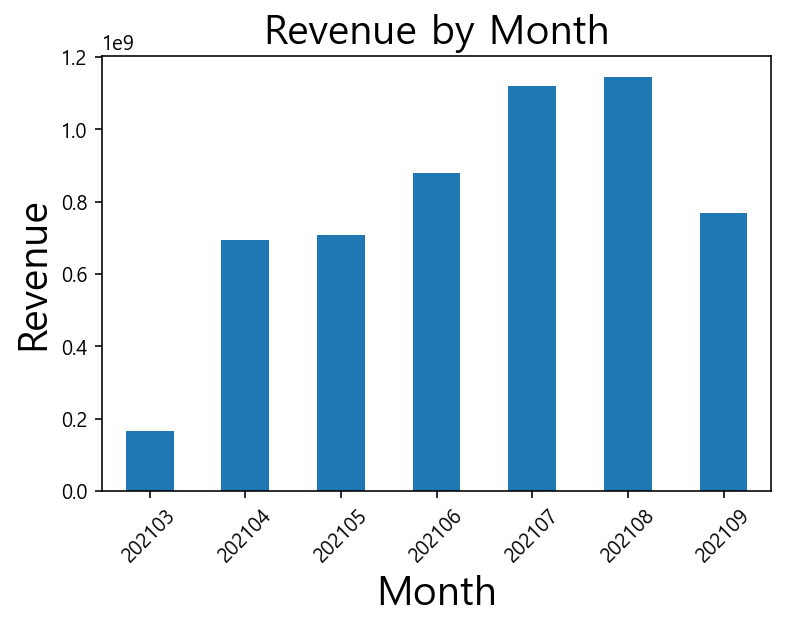

In [43]:
COLORS = sns.color_palette()

def plot_bar(df_condition_B2C, xlabel, ylabel, title, color=COLORS[0], figsize=(6, 4), rotation=45):
    plot = df_condition_B2C.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=20)
    plot.set_ylabel(ylabel, fontsize=20)
    plot.set_title(title, fontsize=20)
    plot.set_xticklabels(labels=df_condition_B2C.index, rotation=rotation)
                   
plot_bar(rev_by_month, 'Month', 'Revenue', 'Revenue by Month')

Q2. 무슨 요일에 매출이 가장 높을까?  

In [56]:
# 0 - 월 / 1 - 화 / 2 - 수 / 3 - 목 / 4 - 금 / 5 - 토 / 6 - 일
rev_by_dow = df_condition_B2C.set_index('completed_at').groupby(lambda date:date.dayofweek).sum()['transaction_amount']

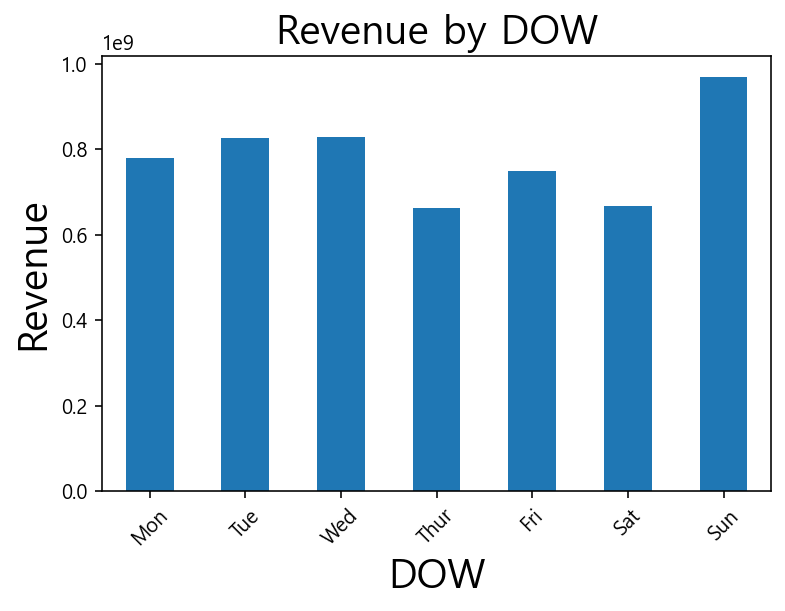

In [57]:
DAY_OF_WEEK = np.array(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
rev_by_dow.index = DAY_OF_WEEK[rev_by_dow.index]
plot_bar(rev_by_dow, 'DOW', 'Revenue', 'Revenue by DOW')

Q3. 어떤 시간대에 가장 많이 사람들이 구매할까?   

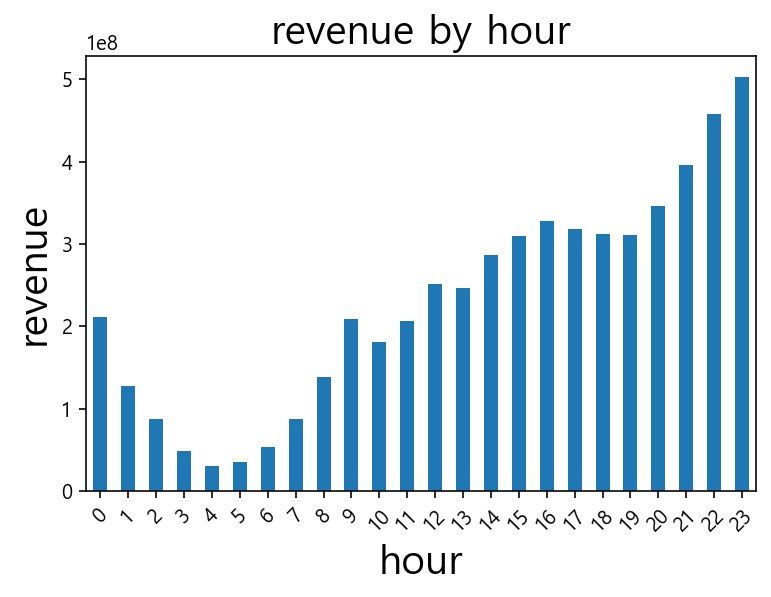

In [58]:
rev_by_hour = df_condition_B2C.set_index('completed_at').groupby(lambda date:date.hour).sum()['transaction_amount']
plot_bar(rev_by_hour, 'hour', 'revenue', 'revenue by hour')

### 

___매출 데이터로부터 insight___

 Q1. 월별 매출 추이는 어떻게 다를까?     
   A1. 7, 8월에 가장 높음.(3월은 28일부터 반영/  9월은 26 ~ 30일 데이터가 반영되지 않았음)  
   
Q2. 무슨 요일에 매출이 가장 높을까?  
   A2. 일요일 매출이 압도적/ 목요일과 토요일은 상대적으로 낮은편.  
   
Q3. 어떤 시간대에 가장 많이 사람들이 구매할까?   
   A3. 저녁 8시부터 증가세를 보여 밤 11시에 절정. 새벽 1시 이후로 넘어가면서 급락함.  

##  4-1. 쿠폰 마케팅 전략
Q1. 쿠폰은 실결제에 영향을 얼마나 미칠까?  
Q2. 어떤 금액대 쿠폰이 가장 많이 사용되었을까?   
-> 패캠 측에서 가장 많이 제공하는 쿠폰인지?  
-> 맞다면, 많이 제공했기에 가장 높은 비율을 차지. 아니라면, 고객에게 가장 매력적임

### 쿠폰 데이터 및 분포 확인

#### 쿠폰 데이터 확인

In [90]:
# 쿠폰을 사용하지 않은 결제 건수
(df_condition_B2C['coupon_title'] == '미사용').sum()

27357

In [91]:
# 쿠폰을 사용한 결제 건수
(df_condition_B2C['coupon_title'] != '미사용').sum()

21453

In [92]:
# 쿠폰 값 파악하기 => 0 ~ 2,000,000 으로 금액대 다양함
# 2,000,000원 금액의 쿠폰이 있을까? -> OUTLIAR로 판단 -> 어떤 금액대까지 유효한 결과가 나올지 판단해야 함

pd.options.display.float_format = '{:.5f}'.format
df_condition_B2C['coupon_discount_amount'].describe()

count    48810.00000
mean     21809.58912
std      42833.53885
min          0.00000
25%          0.00000
50%          0.00000
75%      20000.00000
max     409000.00000
Name: coupon_discount_amount, dtype: float64

#### 쿠폰 사용 여부별 분포

In [93]:
# 쿠폰 사용 여부에 대한 새로운 컬럼 추가
df_condition_B2C['coupon_gb'] = '쿠폰 미사용'
df_condition_B2C.loc[df_condition_B2C['coupon_discount_amount'] > 0, 'coupon_gb'] = '쿠폰 사용'

In [94]:
# 쿠폰 금액대별 설정 위해, coupon_discount_category 컬럼 추가
df_condition_B2C["coupon_discount_category"] = ' '

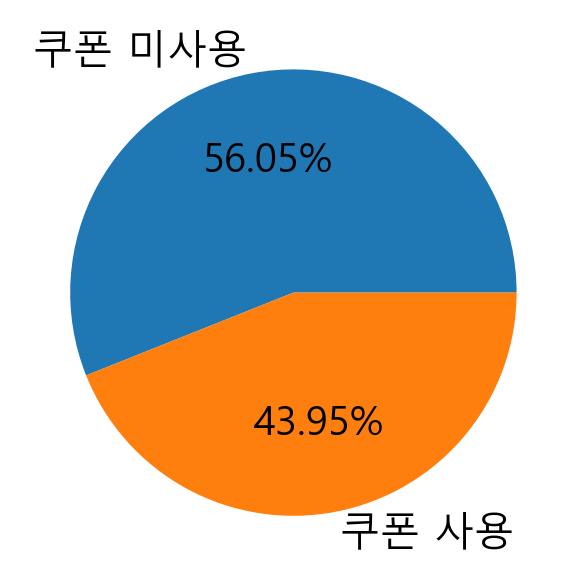

In [95]:
# pie 차트
plt.figure(figsize = (5,8))
plt.pie(df_condition_B2C["coupon_gb"].value_counts(), labels = df_condition_B2C["coupon_gb"].value_counts().index, autopct = '%0.2f%%', textprops = {'fontsize':20})
plt.show()

#### 쿠폰 금액별 분포

In [96]:
# 쿠폰 금액대별 구분
df_condition_B2C.loc[df_condition_B2C["coupon_discount_amount"] == 0.0 , "coupon_discount_category"] = '00. 쿠폰 미사용'
df_condition_B2C.loc[(0.0 < df_condition_B2C["coupon_discount_amount"]) & (df_condition_B2C["coupon_discount_amount"] <= 10000), "coupon_discount_category"] = '01. 만원이하'
df_condition_B2C.loc[(10000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 20000) , "coupon_discount_category"] = '02. 만원 초과 이만원 이하'
df_condition_B2C.loc[(20000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 30000) , "coupon_discount_category"] = '03. 이만원 초과 삼만원 이하'
df_condition_B2C.loc[(30000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 40000) , "coupon_discount_category"] = '04. 삼만원 초과 사만원 이하'
df_condition_B2C.loc[(40000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 50000) , "coupon_discount_category"] = '05. 사만원 초과 오만원 이하'
df_condition_B2C.loc[(50000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 60000) , "coupon_discount_category"] = '06. 오만원 초과 육만원 이하'
df_condition_B2C.loc[(60000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 70000) , "coupon_discount_category"] = '07. 육만원 초과 칠만원 이하'
df_condition_B2C.loc[(70000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 80000) , "coupon_discount_category"] = '08. 칠만원 초과 팔만원 이하'
df_condition_B2C.loc[(80000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 90000) , "coupon_discount_category"] = '09. 팔만원 초과 구만원 이하'
df_condition_B2C.loc[(90000 < df_condition_B2C["coupon_discount_amount"]) &(df_condition_B2C["coupon_discount_amount"] <= 100000) , "coupon_discount_category"] = '10. 구만원 초과 십만원 이하'
df_condition_B2C.loc[(100000 < df_condition_B2C["coupon_discount_amount"]) , "coupon_discount_category"] = '11. 십만원 초과'

In [97]:
df_condition_B2C['coupon_discount_category'].value_counts().sum()

48810

In [98]:
# 내용 확인
df_condition_B2C['coupon_discount_category'].value_counts()

00. 쿠폰 미사용           27357
02. 만원 초과 이만원 이하      6680
01. 만원이하              4378
11. 십만원 초과            4168
03. 이만원 초과 삼만원 이하     3384
10. 구만원 초과 십만원 이하      707
05. 사만원 초과 오만원 이하      667
09. 팔만원 초과 구만원 이하      393
06. 오만원 초과 육만원 이하      355
04. 삼만원 초과 사만원 이하      323
08. 칠만원 초과 팔만원 이하      237
07. 육만원 초과 칠만원 이하      161
Name: coupon_discount_category, dtype: int64

In [99]:
# 쿠폰 사용 금액별 갯수 확인
df_groupby = df_condition_B2C.groupby(["coupon_discount_category"])["coupon_discount_category"].count().to_frame()
df_groupby

,coupon_discount_category
coupon_discount_category,
00. 쿠폰 미사용,27357
01. 만원이하,4378
02. 만원 초과 이만원 이하,6680
03. 이만원 초과 삼만원 이하,3384
04. 삼만원 초과 사만원 이하,323
05. 사만원 초과 오만원 이하,667
06. 오만원 초과 육만원 이하,355
07. 육만원 초과 칠만원 이하,161
08. 칠만원 초과 팔만원 이하,237


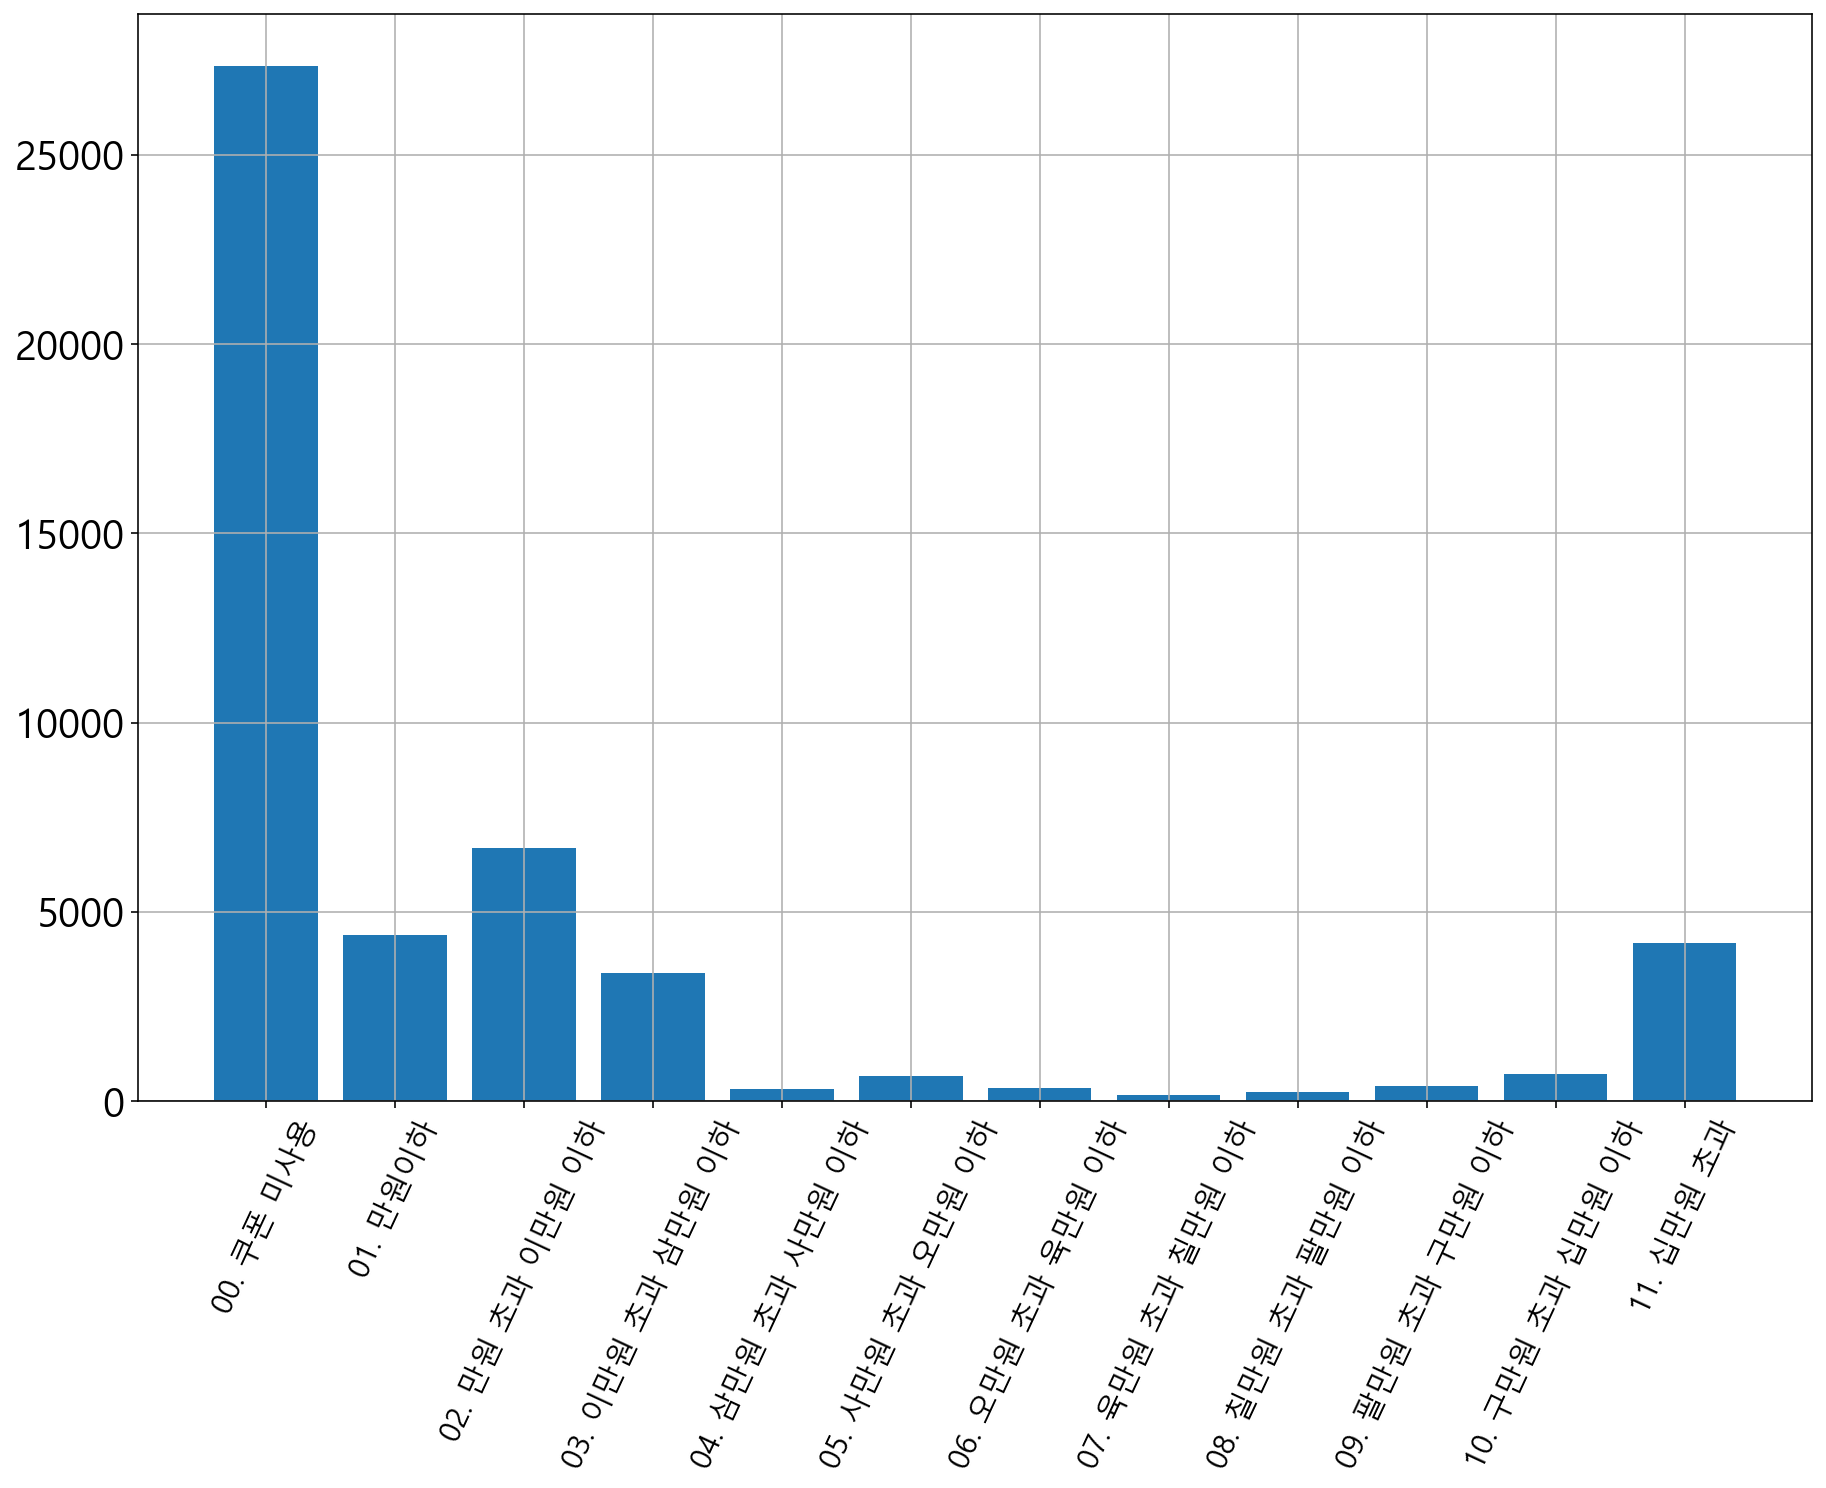

In [100]:
plt.figure(figsize = (15,10))
plt.bar(df_groupby.index, df_groupby["coupon_discount_category"])
plt.yticks(size = 20)
plt.xticks(rotation=65, size = 15)
plt.grid(True)

#### coupon_title 별 분포 

In [101]:
df_condition_B2C["coupon_title"].value_counts()

미사용                                                   27357
[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰                               3864
[WELCOME] 온라인 강의 3만원 할인쿠폰                              2143
[웰컴쿠폰] 올인원 패키지 1만원 할인 쿠폰                               1790
[WELCOME] 온라인 강의 2만원 할인쿠폰                              1656
                                                      ...  
한 번에 끝내는 반복 업무 자동화 초격차 패키지 사용 가능 쿠폰                       1
[50% 할인 쿠폰] The RED : 김영하 할인 쿠폰                           1
[재결제쿠폰]The RED 조형기 출시할인                                   1
[할인쿠폰] 아이패드 드로잉 초격차 작가님 전용 5,000원 할인 쿠폰! (듀박스 작가님)        1
[시크릿쿠폰] 초격차 포토샵 활용 20% 할인쿠폰_미사용 재발급                       1
Name: coupon_title, Length: 189, dtype: int64

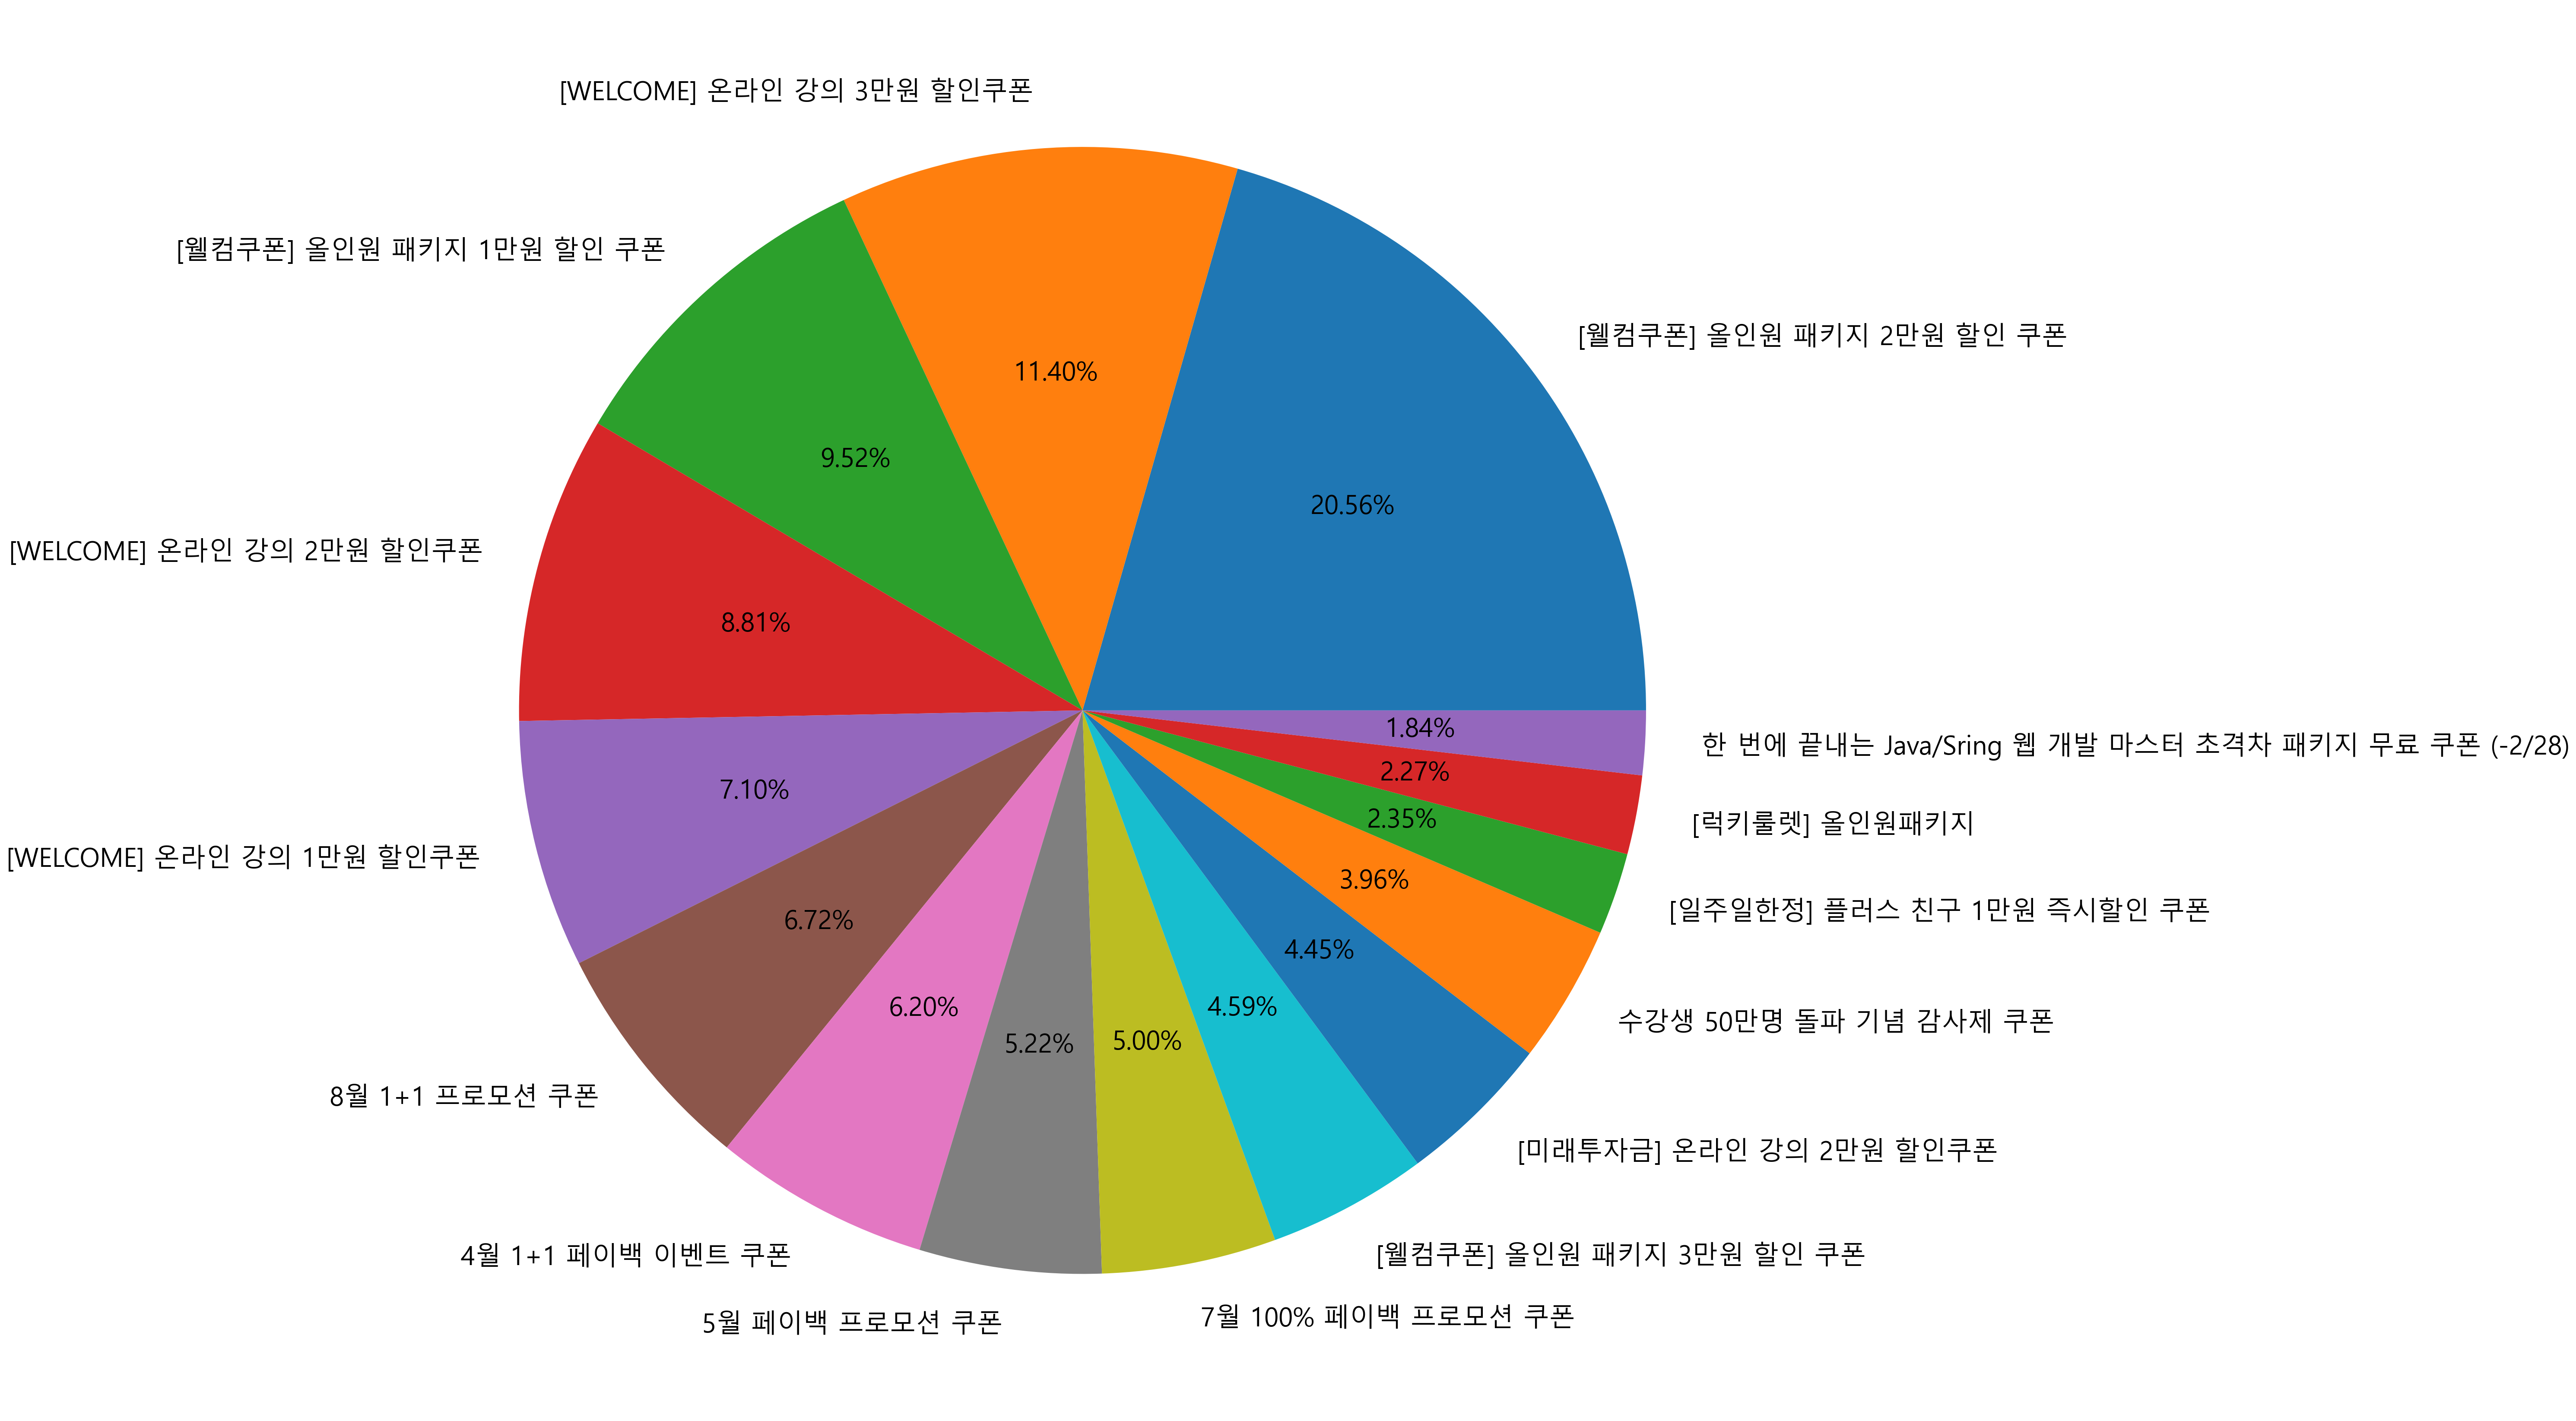

In [106]:
# 쿠폰 사용양 상위 15개 분포 확인(미사용 제외)
plt.figure(figsize = (30,30))
plt.pie(df_condition_B2C[df_condition_B2C["coupon_title"] != "미사용"]["coupon_title"].value_counts().head(15), labels = df_condition_B2C[df_condition_B2C["coupon_title"] != "미사용"]["coupon_title"].value_counts().head(15).index, autopct = '%0.2f%%', textprops = {'fontsize':30})
plt.show()

## 4-2. 쿠폰 마케팅 전략
언제 쿠폰 push notification 을 보내면 매출로 가장 많이 이어지게 될까?

1 시간 단위 

In [107]:
order_by_hour = df_condition_B2C.set_index('completed_at').groupby(lambda date: date.hour).count()['customer_id']

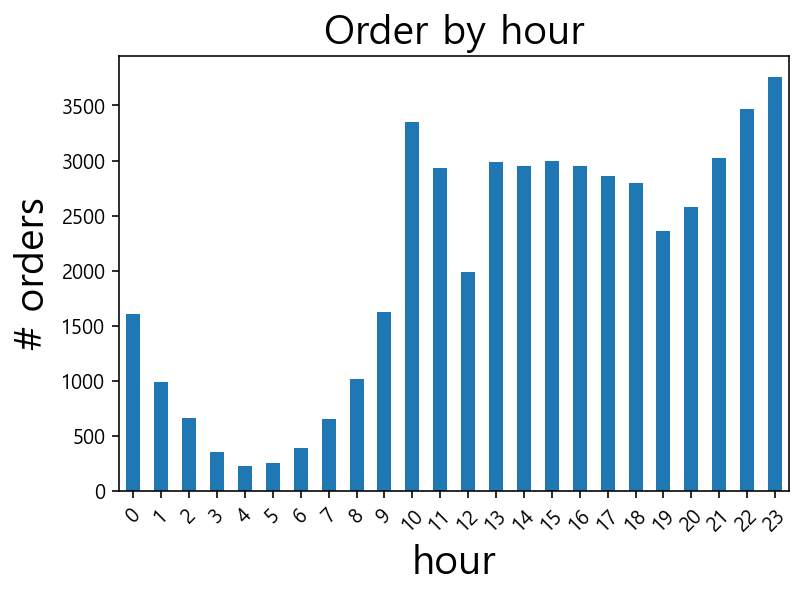

In [108]:
plot_bar(order_by_hour, 'hour', '# orders', 'Order by hour')

30분 단위

In [109]:
def half_an_hour(date):
    minute = ':00'
    if date.minute > 30:
        minute = ':30'
    hour = str(date.hour)
    if date.hour < 10:
        hour = '0' + hour
    
    return hour + minute

In [ ]:
order_by_hour_half = df_condition_B2C.set_index('completed_at').groupby(half_an_hour).count()['customer_id']

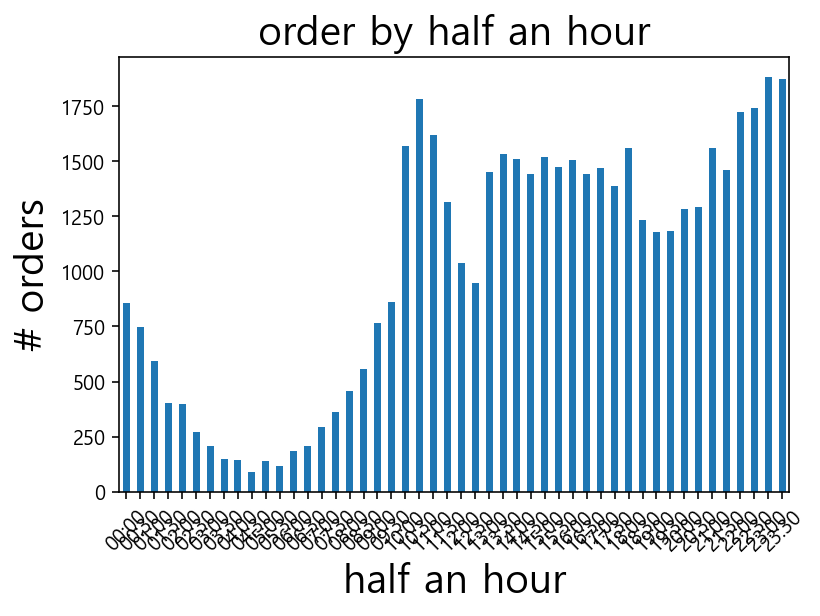

In [ ]:
plot_bar(order_by_hour_half, 'half an hour', '# orders', 'order by half an hour')

## 노트북/ 태블릿을 같이 판매하면 매출이 올라갈까?

In [ ]:
# 맥북/아이패드/삼성 노트북 등 전자기기를 묶어 판매한 프로모션 추출
df_freegift = df_condition_B2C[df_condition_B2C['course_title'].str.contains('현물')]

In [ ]:
gift_rev_by_month = df_freegift.set_index('completed_at').groupby(extract_month).sum()['transaction_amount']
gift_rev_by_month

202105     9147000
202107    60530000
202109    42800000
Name: transaction_amount, dtype: int64

In [ ]:
# 매출은 총 매출대비 7,9월은 5프로 정도 차지 / 5월은 1프로 차지
# 5월은 삼성사 / 7,9 는 애플사
gift_rev_by_month / rev_by_month

202103       NaN
202104       NaN
202105   0.01291
202106       NaN
202107   0.05407
202108       NaN
202109   0.05558
Name: transaction_amount, dtype: float64

In [ ]:
# 판매된 기간 동안 프로모션 상품 매출이 차지하는 비율 

#### 뭔 지 모르겠음ㅜㅜ

In [ ]:
df_condition_B2C["date"]  = df_condition_B2C["completed_at"].dt.date

In [ ]:
aa = df_condition_B2C.groupby(["category_title",'date'])["transaction_amount"].sum().to_frame()

In [ ]:
aa.query('category_title == "프로그래밍"')

transaction_amount
category_title date                          
프로그래밍          2021-03-28             7293675
               2021-03-29             4930567
               2021-03-30             7538527
               2021-03-31            19843059
               2021-04-01             4628300
               2021-04-02             3889067
               2021-04-03             5249300
               2021-04-04             7740000
               2021-04-05             4095900
               2021-04-06             4147400
               2021-04-07             6493266
               2021-04-08             5512600
               2021-04-09             5179500
               2021-04-10             6573400
               2021-04-11            13171200
               2021-04-12             4134842
               2021-04-13             3511692
               2021-04-14             6115575
               2021-04-15             6074930
               2021-04-16             6169409
               2021-04-17             5828400
               2021-04-18            10045025
               2021-04-19             1140078
               2021-04-20             3560325
               2021-04-21             4253767
               2021-04-22             3106687
               2021-04-23             7224750
               2021-04-24             5702750
               2021-04-25             5608375
               2021-04-26             7720428
               2021-04-27             9053288
               2021-04-28             6860600
               2021-04-29            10568401
               2021-04-30            19309400
               2021-05-01             5388000
               2021-05-02             5844000
               2021-05-03             1835000
               2021-05-04             5127400
               2021-05-05             4424485
               2021-05-06             4406670
               2021-05-07             6503667
               2021-05-08             6224400
               2021-05-09             8161500
               2021-05-10             4552915
               2021-05-11             7665869
               2021-05-12             5891000
               2021-05-13             5608567
               2021-05-14             7528542
               2021-05-15             6231900
               2021-05-16            12645400
               2021-05-17             6454267
               2021-05-18             4357900
               2021-05-19             4480900
               2021-05-20             5173919
               2021-05-21             7945800
               2021-05-22             4828900
               2021-05-23            12893300
               2021-05-24             3737900
               2021-05-25             4845749
               2021-05-26             4707884
               2021-05-27             5296750
               2021-05-28             6129500
               2021-05-29             5699300
               2021-05-30             7367000
               2021-05-31            24703567
               2021-06-01             4607500
               2021-06-02             3318459
               2021-06-03             4855788
               2021-06-04             4935434
               2021-06-05             4619500
               2021-06-06            10834600
               2021-06-07             4782967
               2021-06-08             5305210
               2021-06-09             2624767
               2021-06-10             7422600
               2021-06-11             7117976
               2021-06-12             5551400
               2021-06-13             8154100
               2021-06-14             1894300
               2021-06-15             4538900
               2021-06-16             3759590
               2021-06-17             7151708
               2021-06-18             3790905
               2021-06-19             4508500
               2021-06-20            10341900
               2021-06-21

## 매출 예측 - 시계열 모델링: Linear Regression Prophet

- 측정하고자 하는 것이 무엇인가 정확하게 정하고, 컬럼들 정해줘야 함.
- 여러 Column들을 계산해서 넣어보며, 가장 최적화된 모델 설계 필요 함
- 그냥 코드처럼 복사해서 붙인다고 사용할 수 있는게 아니였음ㅜㅜㅜㅜ
- sklearn,Prophet 등의 패키지 사용시 필요한 Column과 정해진 컬럼명이 있음
- LSDM : 어떤 천재가 가장 최적화된 모델을 설계한 것이라고 보면 됨. 해당하는 Column명을 지정해주면 그 알고리즘에따라 주가예측해줌.

https://hyperconnect.github.io/2020/03/09/prophet-package.html
https://m.blog.naver.com/jisu0259/222071662912

시계열 관련,datetime인덱스 - https://blog.naver.com/PostView.nhn?blogId=bnormal16&logNo=222024908931&categoryNo=17&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=searchㅡ

sklearn 부동산 분석 :https://roboreport.co.kr/scikit-learn%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%98%EC%97%AC-%EB%B6%80%EB%8F%99%EC%82%B0-%EA%B0%80%EA%B2%A9-%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0-4-linear-regression-%EC%82%AC%EC%9A%A9%EB%B2%95/

Prophet - 옵션 설정법 https://ichi.pro/ko/facebook-prophet-eul-sayonghan-sigyeyeol-bunseog-jagdong-wonli-mich-sayong-bangbeob-265389504990778
https://ichi.pro/ko/python-eulo-sigyeyeol-yecheug-eul-wihan-facebook-prophet-1-bu-239090574793501

Prophet 사용 - 단순 시계열 분석 가능 / 시간의 흐름에 따른 

In [ ]:
일자별 매출액 비교 추이 분석

월, 일, 요일, 에 따른 매출액 추이

In [ ]:
#### 분석용 데이터 프레임 생성

In [28]:
df_prophet = df_condition_B2C.loc[:,["completed_at" , "transaction_amount"]]

In [29]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48810 entries, 0 to 48809
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   completed_at        48810 non-null  datetime64[ns]
 1   transaction_amount  48810 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 762.8 KB


In [30]:
df_prophet_sum = df_prophet.groupby(df_prophet['completed_at'].dt.strftime("%Y-%m-%d"))["transaction_amount"].sum().reset_index()

In [31]:
df_prophet_sum 

,completed_at,transaction_amount
0,2021-03-28,24867350
1,2021-03-29,30996743
2,2021-03-30,35039494
3,2021-03-31,75984743
4,2021-04-01,17053155
...,...,...
177,2021-09-21,24661500
178,2021-09-22,57519650
179,2021-09-23,8979352
180,2021-09-24,32536684


In [32]:
# 데이터의 index를 초기화하고 컬럼명을 바꾼다.
count = df_prophet_sum
count = count.rename(columns={'completed_at':'ds', 'transaction_amount':'y'})
# Prophet() 모델을 읽어와서 
# fit로 학습한다.
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(count) #학습데이터 3~8월 , 9월 데이터는 따로 분리해서 데이터프레임형태로 들고있기 (TEST)

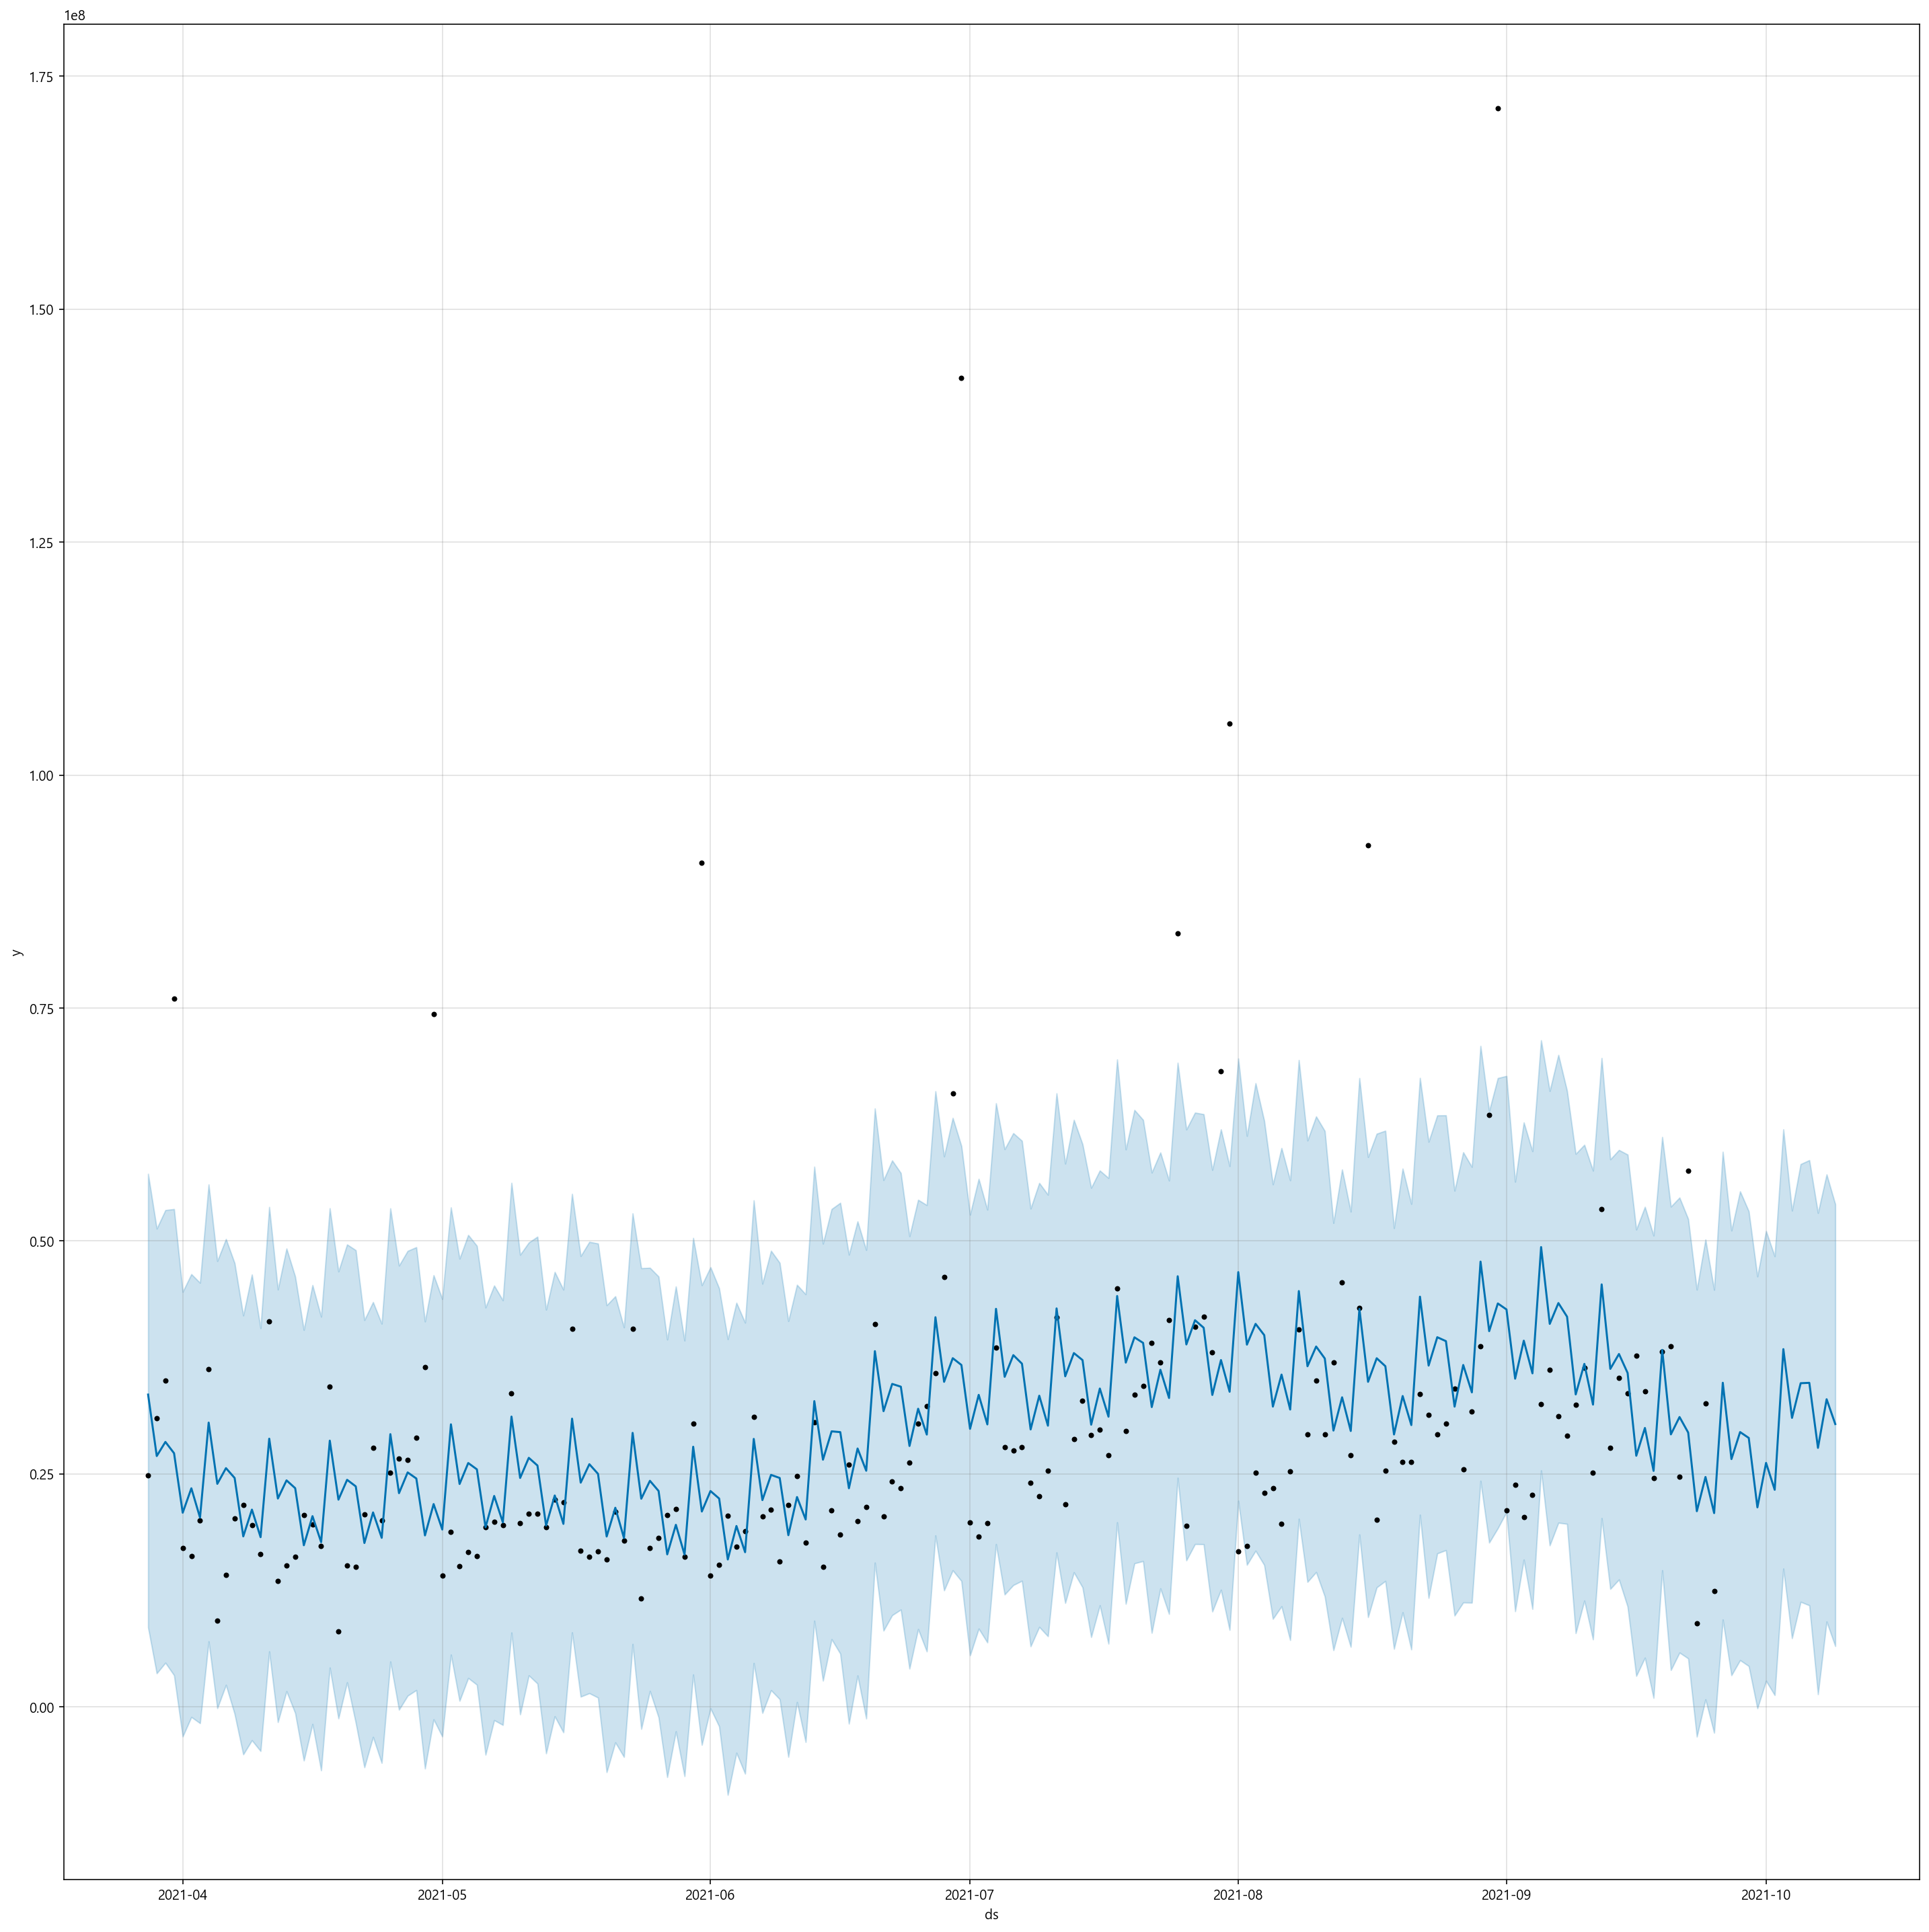

In [33]:
# freq -예측할 단위. y,m,d (년,월,일) 
# periods 는 예측할 기간을 입력하면됩니다. 
future=model.make_future_dataframe(periods=30, freq= 'd')
forecast_count = model.predict(future #ㅛYHAT

# 데이터 시각화 하기
fig = model.plot(forecast_count ,figsize=(20,20))

- 점 : 실제 값
- 파란 선 : 예측치
- 음영 : 오차범위

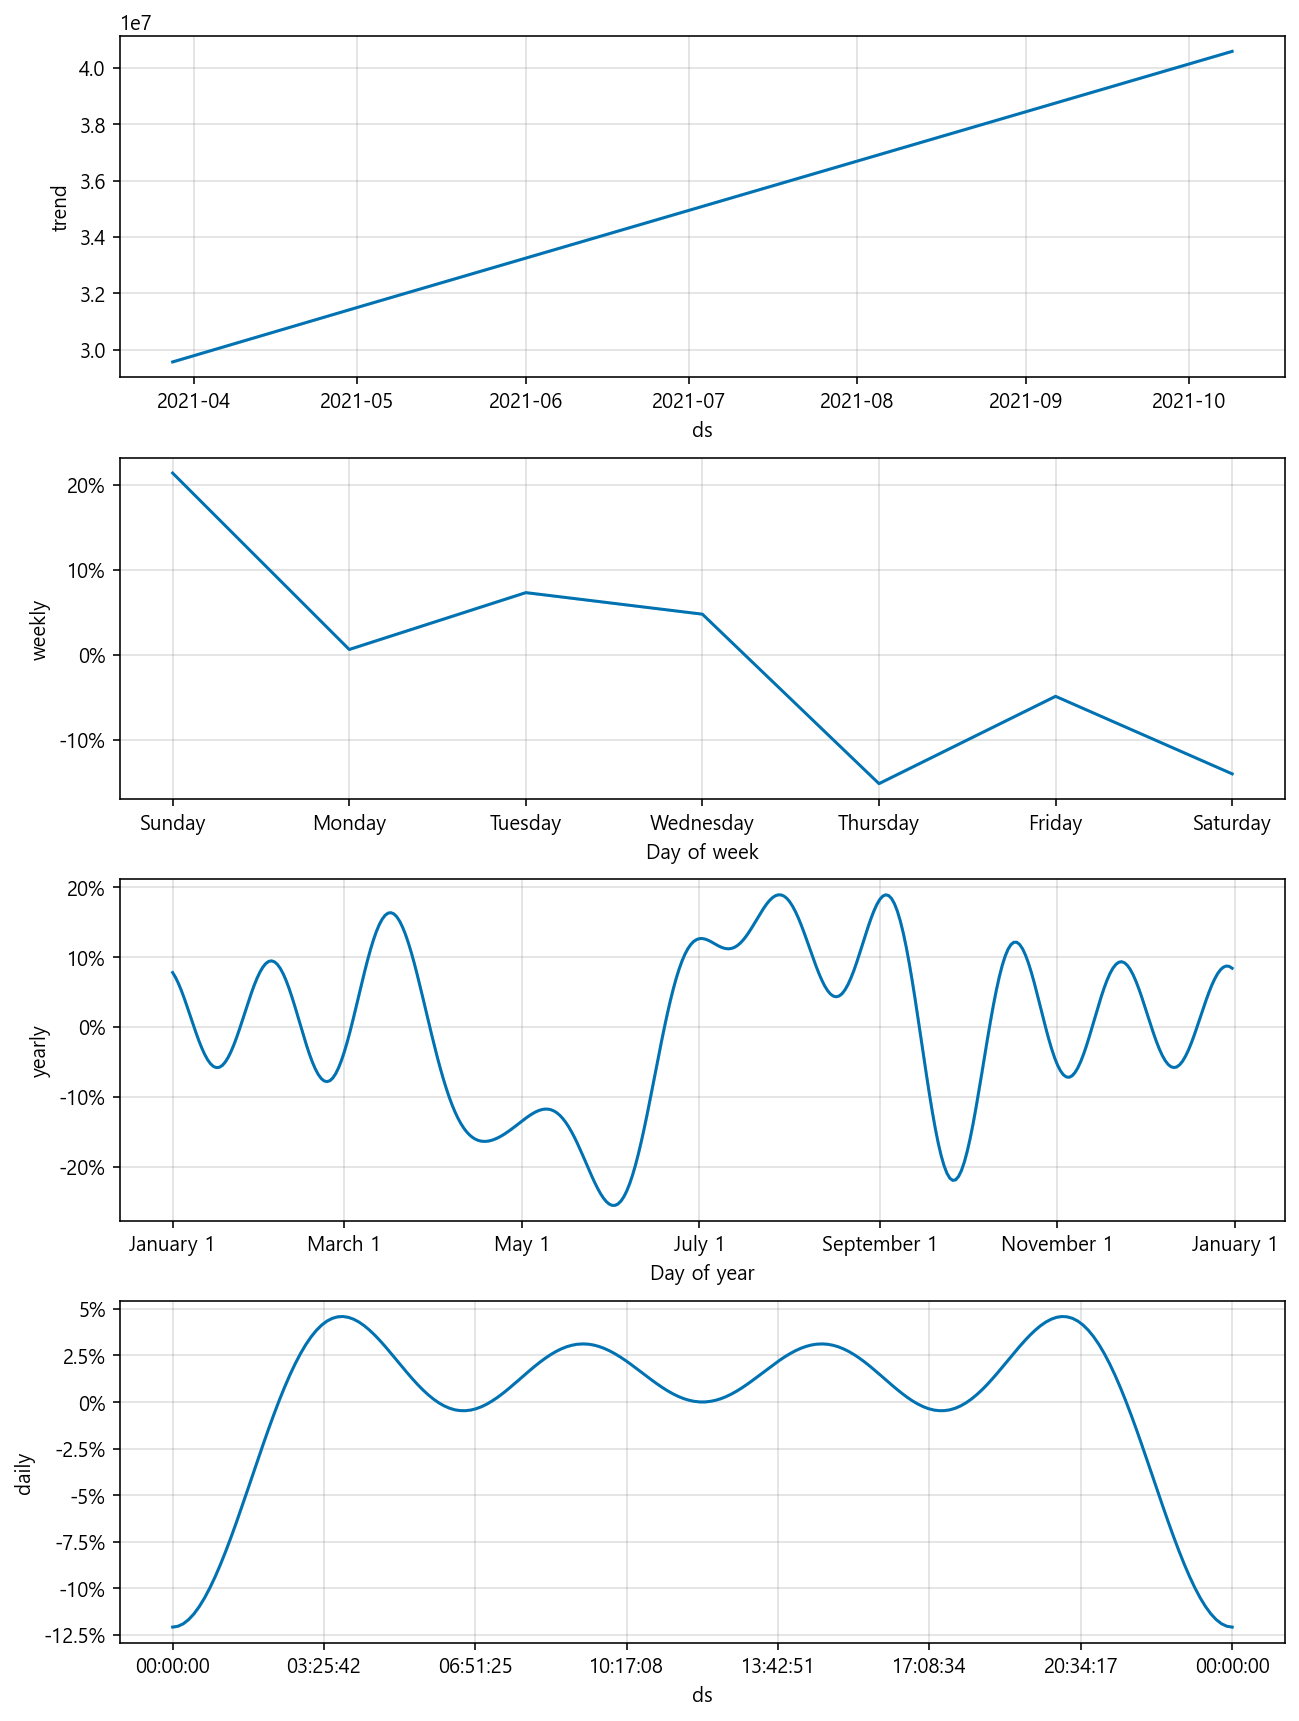

In [34]:
fig2 = model.plot_components(forecast_count)

=> 정확도가 너무 떨어짐

# ARIMA
https://runebook.dev/ko/docs/statsmodels/generated/statsmodels.tsa.arima_model.arima.fit

In [18]:
df_arima = df_condition_B2C.loc[:,["completed_at" , "transaction_amount"]]

In [19]:
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48810 entries, 0 to 48809
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   completed_at        48810 non-null  datetime64[ns]
 1   transaction_amount  48810 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 762.8 KB


In [21]:
df_arima_sum = df_arima.groupby(df_arima['completed_at'].dt.strftime("%Y-%m-%d"))["transaction_amount"].sum().reset_index()

In [23]:
df_arima_sum 

,completed_at,transaction_amount
0,2021-03-28,24867350
1,2021-03-29,30996743
2,2021-03-30,35039494
3,2021-03-31,75984743
4,2021-04-01,17053155
...,...,...
177,2021-09-21,24661500
178,2021-09-22,57519650
179,2021-09-23,8979352
180,2021-09-24,32536684


In [66]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_arima_sum['transaction_amount'], order=(2,1,2))
model_fit = model.fit(trend='nc',full_output=True, disp=1,seasonal=True,)
print(model_fit.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.transaction_amount   No. Observations:                  181
Model:                   ARIMA(2, 1, 2)   Log Likelihood               -3295.879
Method:                         css-mle   S.D. of innovations       19400502.910
Date:                  Tue, 19 Oct 2021   AIC                           6601.759
Time:                          01:54:31   BIC                           6617.751
Sample:                               1   HQIC                          6608.242
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ar.L1.D.transaction_amount     1.1081      0.082     13.503      0.000       0.947       1.269
ar.L2.D.transaction_amount    -0.1780      0.076     -2.356      0.

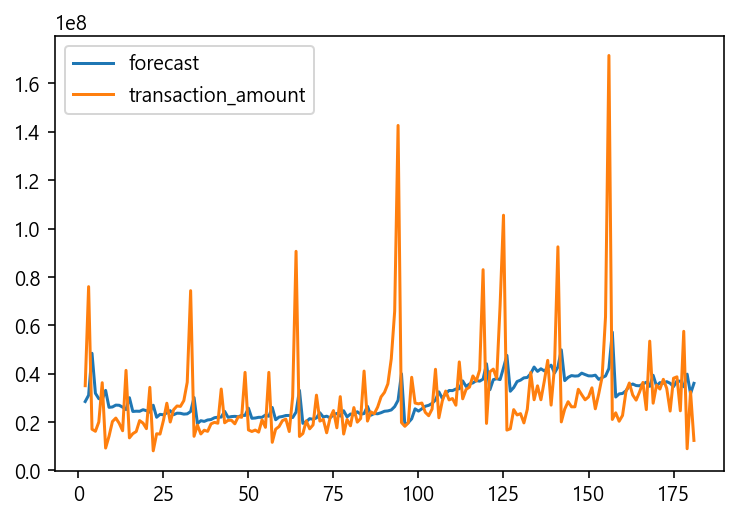

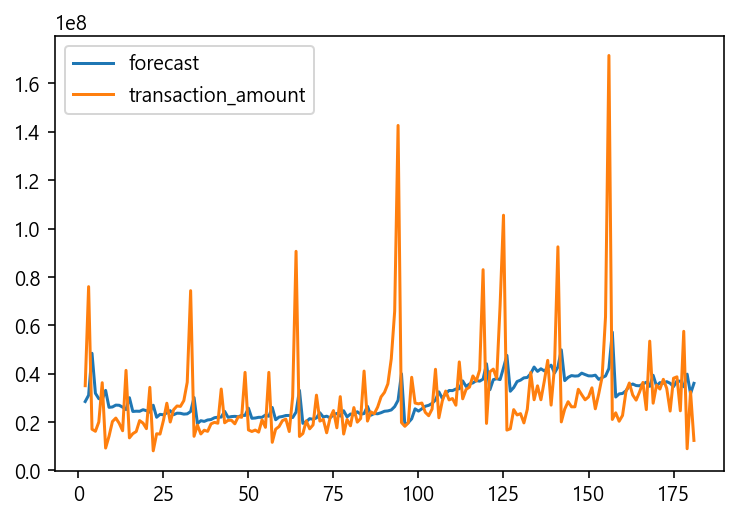

In [67]:
model_fit.plot_predict()

=> 정확도가 너무 떨어짐

<AxesSubplot:>

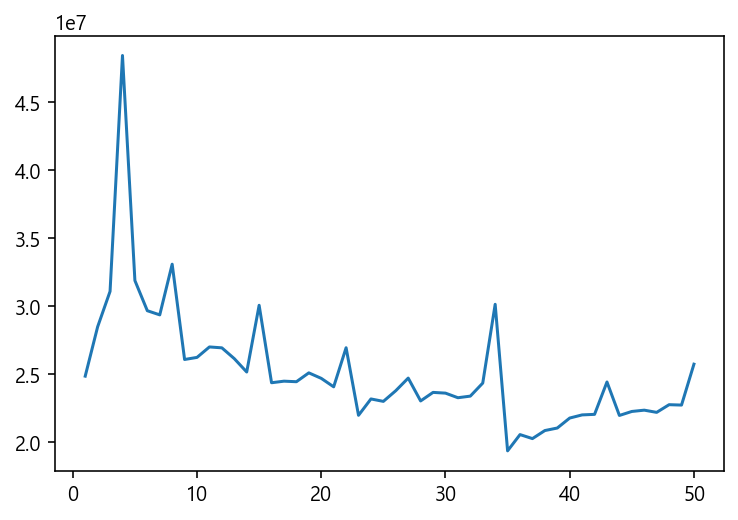

In [64]:
model_fit.predict(1, 50, typ='levels').plot()

# LSTM
https://github.com/roboreport/mltoolkit/blob/master/script/LSTM_with_Keras_(house_index_prediction)_post.ipynb

In [96]:
df_arima_sum['completed_at'] = pd.to_datetime(df_arima_sum['completed_at'])
df_arima_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   completed_at        182 non-null    datetime64[ns]
 1   transaction_amount  182 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 KB


In [153]:
df_arima_sum.set_index("completed_at")

,transaction_amount
completed_at,
2021-03-28,24867350
2021-03-29,30996743
2021-03-30,35039494
2021-03-31,75984743
2021-04-01,17053155
...,...
2021-09-21,24661500
2021-09-22,57519650
2021-09-23,8979352


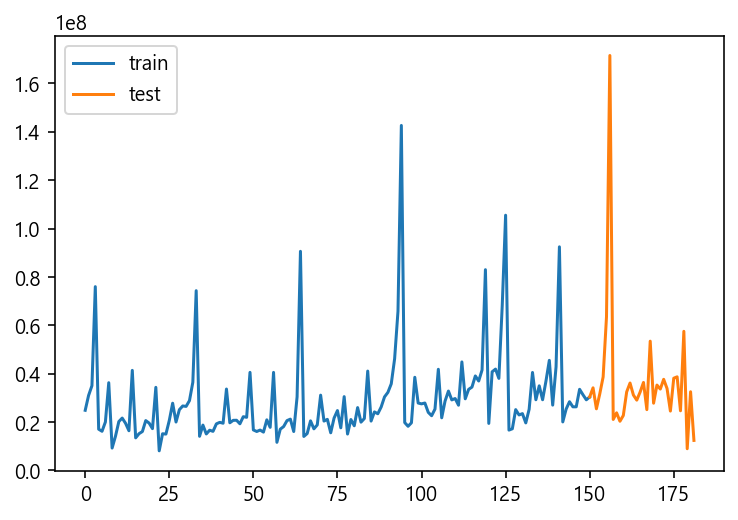

In [159]:
train = df_arima_sum.loc[:150, ['transaction_amount']]
test = df_arima_sum.loc[150:, ['transaction_amount']]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [160]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.12455029],
       [0.17011545],
       [0.20016876],
       [0.50455072],
       [0.06646052],
       [0.06006665],
       [0.08865172],
       [0.20937789],
       [0.0085201 ],
       [0.04484315],
       [0.09003034],
       [0.10066413],
       [0.08458168],
       [0.0617396 ],
       [0.24726614],
       [0.0399125 ],
       [0.05270645],
       [0.05927837],
       [0.09293969],
       [0.08527436],
       [0.06819949],
       [0.195116  ],
       [0.        ],
       [0.05251095],
       [0.05147953],
       [0.09337794],
       [0.14632932],
       [0.08854007],
       [0.12650072],
       [0.13789022],
       [0.1365553 ],
       [0.15430278],
       [0.21083345],
       [0.49217842],
       [0.04461566],
       [0.0790702 ],
       [0.05186271],
       [0.06336812],
       [0.05986355],
       [0.08290065],
       [0.08750372],
       [0.08486565],
       [0.18993756],
       [0.08617512],
       [0.09372287],
       [0.09397215],
       [0.08307458],
       [0.104

In [161]:
train_sc_df = pd.DataFrame(train_sc, columns=['transaction_amount'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['transaction_amount'], index=test.index)
train_sc_df.head()

,transaction_amount
0,0.124550
1,0.170115
2,0.200169
3,0.504551
4,0.066461


In [162]:

for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['transaction_amount'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['transaction_amount'].shift(s)

train_sc_df.head(13)

,transaction_amount,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
0,0.124550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.066461,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.060067,0.066461,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.088652,0.060067,0.066461,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN,NaN
7,0.209378,0.088652,0.060067,0.066461,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN,NaN
8,0.008520,0.209378,0.088652,0.060067,0.066461,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN,NaN
9,0.044843,0.008520,0.209378,0.088652,0.060067,0.066461,0.504551,0.200169,0.170115,0.124550,NaN,NaN,NaN


In [164]:
X_train = train_sc_df.dropna().drop('transaction_amount', axis=1)
y_train = train_sc_df.dropna()[['transaction_amount']]

X_test = test_sc_df.dropna().drop('transaction_amount', axis=1)
y_test = test_sc_df.dropna()[['transaction_amount']]



X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
12,0.100664,0.090030,0.044843,0.008520,0.209378,0.088652,0.060067,0.066461,0.504551,0.200169,0.170115,0.124550
13,0.084582,0.100664,0.090030,0.044843,0.008520,0.209378,0.088652,0.060067,0.066461,0.504551,0.200169,0.170115
14,0.061740,0.084582,0.100664,0.090030,0.044843,0.008520,0.209378,0.088652,0.060067,0.066461,0.504551,0.200169
15,0.247266,0.061740,0.084582,0.100664,0.090030,0.044843,0.008520,0.209378,0.088652,0.060067,0.066461,0.504551
16,0.039913,0.247266,0.061740,0.084582,0.100664,0.090030,0.044843,0.008520,0.209378,0.088652,0.060067,0.066461


In [165]:
y_train.head()


,transaction_amount
12,0.084582
13,0.061740
14,0.247266
15,0.039913
16,0.052706


In [166]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
#print(X_train)
print(y_train.shape)
#print(y_train)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(139, 12)
(139, 1)


In [167]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(139, 12, 1)
[[[0.10066413]
  [0.09003034]
  [0.04484315]
  ...
  [0.20016876]
  [0.17011545]
  [0.12455029]]

 [[0.08458168]
  [0.10066413]
  [0.09003034]
  ...
  [0.50455072]
  [0.20016876]
  [0.17011545]]

 [[0.0617396 ]
  [0.08458168]
  [0.10066413]
  ...
  [0.06646052]
  [0.50455072]
  [0.20016876]]

 ...

 [[0.18903286]
  [0.13524281]
  [0.13529138]
  ...
  [0.27807658]
  [0.21428648]
  [0.15697691]]

 [[0.17244206]
  [0.18903286]
  [0.13524281]
  ...
  [0.1404718 ]
  [0.27807658]
  [0.21428648]]

 [[0.15686399]
  [0.17244206]
  [0.18903286]
  ...
  [0.25784789]
  [0.1404718 ]
  [0.27807658]]]
[[0.08458168]
 [0.0617396 ]
 [0.24726614]
 [0.0399125 ]
 [0.05270645]
 [0.05927837]
 [0.09293969]
 [0.08527436]
 [0.06819949]
 [0.195116  ]
 [0.        ]
 [0.05251095]
 [0.05147953]
 [0.09337794]
 [0.14632932]
 [0.08854007]
 [0.12650072]
 [0.13789022]
 [0.1365553 ]
 [0.15430278]
 [0.21083345]
 [0.49217842]
 [0.04461566]
 [0.0790702 ]
 [0.05186271]
 [0.06336812]
 [0.05986355]
 [0.082

In [168]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model_lstm = Sequential() # Sequeatial Model 
model_lstm.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model_lstm.add(Dense(1)) # output = 1 
model_lstm.compile(loss='mean_squared_error', optimizer='adam') 
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [172]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model_lstm.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.0405
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0277
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0201
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 5/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 00005: early stopping


In [173]:
print(X_test_t)

[[[0.18116484]
  [0.10864662]
  [0.09087049]
  [0.11687023]
  [0.09645242]
  [1.21493904]
  [0.4117754 ]
  [0.22709468]
  [0.17507427]
  [0.12912093]
  [0.19361198]
  [0.16559756]]

 [[0.20837209]
  [0.18116484]
  [0.10864662]
  [0.09087049]
  [0.11687023]
  [0.09645242]
  [1.21493904]
  [0.4117754 ]
  [0.22709468]
  [0.17507427]
  [0.12912093]
  [0.19361198]]

 [[0.17155469]
  [0.20837209]
  [0.18116484]
  [0.10864662]
  [0.09087049]
  [0.11687023]
  [0.09645242]
  [1.21493904]
  [0.4117754 ]
  [0.22709468]
  [0.17507427]
  [0.12912093]]

 [[0.1557748 ]
  [0.17155469]
  [0.20837209]
  [0.18116484]
  [0.10864662]
  [0.09087049]
  [0.11687023]
  [0.09645242]
  [1.21493904]
  [0.4117754 ]
  [0.22709468]
  [0.17507427]]

 [[0.18061316]
  [0.1557748 ]
  [0.17155469]
  [0.20837209]
  [0.18116484]
  [0.10864662]
  [0.09087049]
  [0.11687023]
  [0.09645242]
  [1.21493904]
  [0.4117754 ]
  [0.22709468]]

 [[0.21019878]
  [0.18061316]
  [0.1557748 ]
  [0.17155469]
  [0.20837209]
  [0.18116484]


In [121]:
X_train_t.dtype

dtype('float64')

In [176]:
pred = model_lstm.predict(X_test_t)

pred.shape

(20, 1)

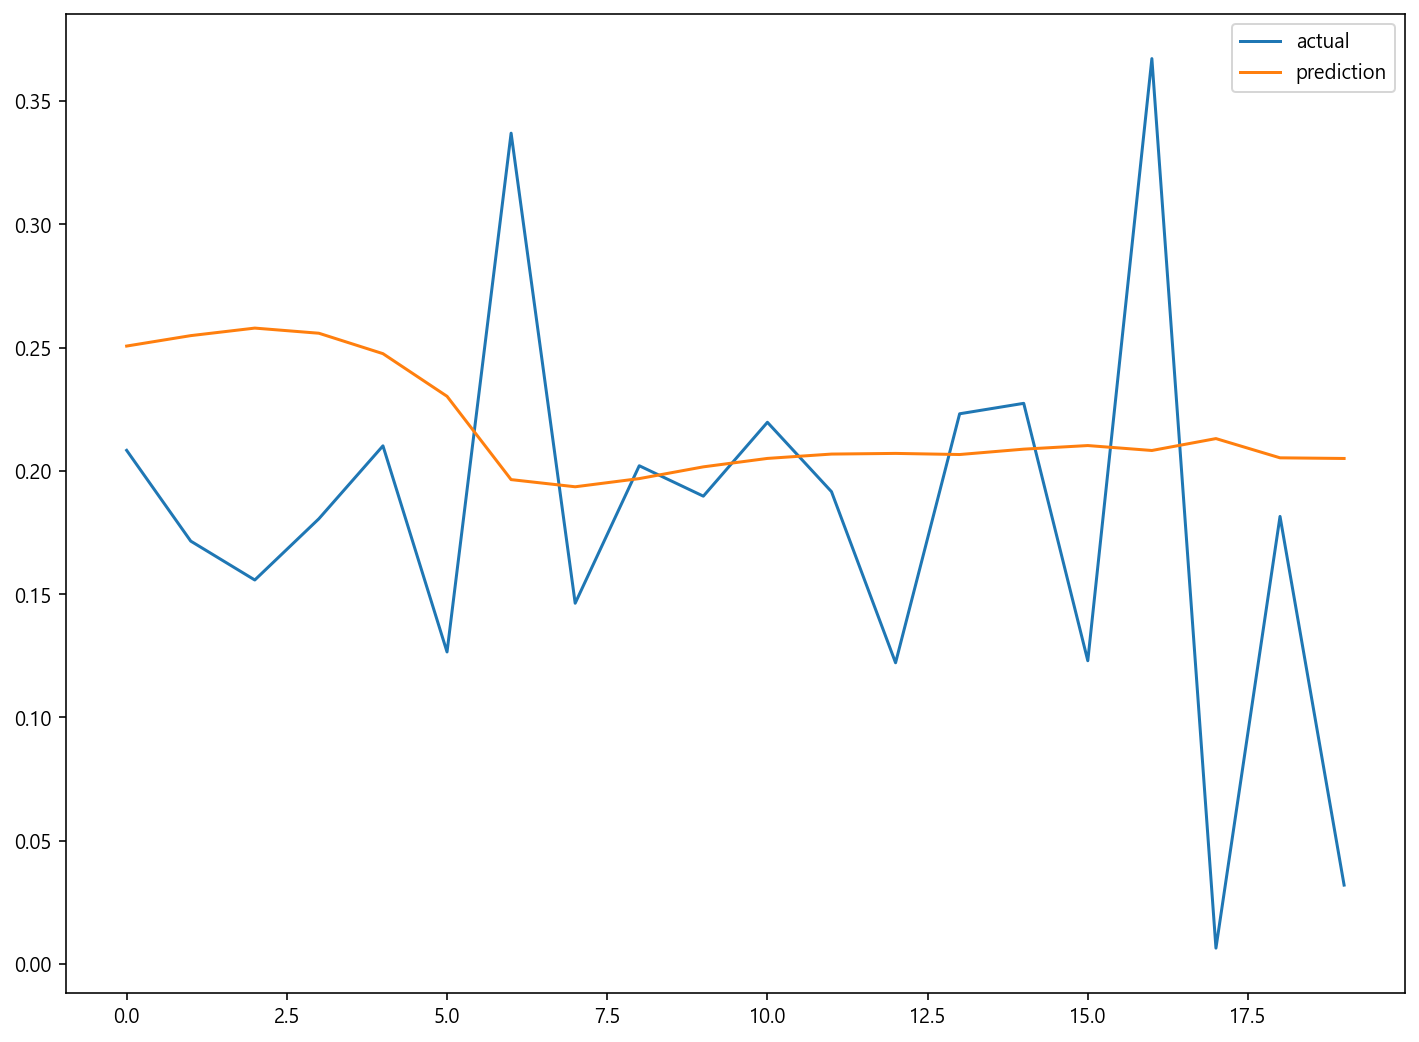

In [177]:
plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

=> 하나도 안맞죠?